In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
import pymannkendall as mk
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import re
from scipy.stats import gumbel_r
import os
from scipy.stats import pearsonr

In [2]:
ls

 Volume in drive C is New Volume
 Volume Serial Number is 3697-C923

 Directory of C:\Users\Annorion\Desktop\TEST\Spatiotemporal_dynamics_and_climatic_drivers

09/01/2025  05:23 PM    <DIR>          .
09/01/2025  01:09 PM    <DIR>          ..
09/01/2025  01:23 PM               179 .gitignore
08/23/2025  10:58 AM    <DIR>          .ipynb_checkpoints
08/23/2025  11:02 AM         3,751,936 Andoh Pressure.xls
08/23/2025  03:25 PM             2,676 annual_counts_p90.csv
08/23/2025  03:25 PM             2,664 annual_counts_p95.csv
08/29/2025  09:09 PM         2,002,296 BENEDICT ANDOH (CHAPTER THREE).docx
08/23/2025  10:22 PM           108,155 boxplot_decadal_extremes.png
08/23/2025  12:32 PM    <DIR>          cleaned_parameters
08/23/2025  12:51 PM    <DIR>          cleaned_parameters_v2
09/01/2025  05:22 PM           764,463 climatology_monthly_rain_by_zone.png
09/01/2025  05:21 PM           867,387 climatology_monthly_temperature_by_zone.png
08/23/2025  11:10 AM        12,954,624 DATA ALL 

# DATA EXTRACTION

In [61]:


# ========= CONFIG =========
INPUT_XLSX = "DATA_ALL_PARA_WEATHER.xls"      # <- your file
OUTPUT_DIR = Path("cleaned_parameters_v2")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Parameter names (case-insensitive). Add variants if needed.
PARAMETERS = [
    "WIND SPEED",
    "RELATIVE HUMIDITY",
    "RAINFALL",
    "MINIMUM TEMPERATURES",
    "MAXIMUM TEMPERATURES",
]
# ==========================

PARAMS_SET = {p.upper(): p for p in PARAMETERS}  # map UPPER -> Canonical

def is_intlike(x):
    try:
        int(str(x).strip())
        return True
    except Exception:
        return False

def detect_parameter(row_vals):
    """Return canonical parameter name if this row contains it, else None."""
    for v in row_vals:
        if pd.isna(v):
            continue
        s = str(v).strip()
        if not s:
            continue
        u = s.upper()
        if u in PARAMS_SET:
            return PARAMS_SET[u]
    return None

def looks_like_data_row(vals):
    """
    Heuristic for data rows:
    [Name(any non-empty string), Year(int), Month(int), Day1, Day2, ...]
    """
    if len(vals) < 4:
        return False
    name = vals[0]
    if pd.isna(name) or not str(name).strip():
        return False
    y = vals[1]
    m = vals[2]
    return is_intlike(y) and is_intlike(m)

def rows_to_records(rows, current_param):
    """Convert buffered rows to tidy records."""
    recs = []
    for r in rows:
        r = list(r)
        if not looks_like_data_row(r):
            continue
        station = str(r[0]).strip()
        year = int(str(r[1]).strip())
        month = int(str(r[2]).strip())

        # Remaining entries are day values
        day_values = r[3:]
        for d_idx, v in enumerate(day_values, start=1):
            if pd.isna(v) or str(v).strip() == "":
                value = np.nan
            else:
                try:
                    value = float(str(v).strip())
                except Exception:
                    # fallback if flags/notes exist
                    try:
                        value = float(str(v).split()[0])
                    except Exception:
                        value = np.nan
            recs.append((current_param, station, year, month, d_idx, value))
    return recs

excel = pd.ExcelFile(INPUT_XLSX)
all_records = []

for sheet in excel.sheet_names:
    df = pd.read_excel(INPUT_XLSX, sheet_name=sheet, header=None, dtype=object)

    current_param = None
    last_param = None          # used if a section starts without repeating a header
    buffer_rows = []

    for _, row in df.iterrows():
        vals = row.tolist()

        # 1) New parameter header?
        maybe_param = detect_parameter(vals)
        if maybe_param:
            # flush previous buffer under previous parameter
            if current_param and buffer_rows:
                all_records.extend(rows_to_records(buffer_rows, current_param))
            current_param = maybe_param
            last_param = current_param
            buffer_rows = []
            continue

        # 2) If we already have a current parameter, collect data rows.
        if current_param:
            if looks_like_data_row(vals):
                buffer_rows.append(vals)
            else:
                # ignore separators/junk rows; DO NOT end parameter on blanks
                pass
            continue

        # 3) No explicit header but we see a data row:
        #    treat it as continuation of the previous parameter section on this sheet.
        if looks_like_data_row(vals) and last_param:
            current_param = last_param
            buffer_rows = [vals]
            continue
        # otherwise ignore until we see a parameter header or a legit continuation

    # flush at end of sheet
    if current_param and buffer_rows:
        all_records.extend(rows_to_records(buffer_rows, current_param))

# ---- Build tidy frame and export ----
long_df = pd.DataFrame(
    all_records,
    columns=["parameter", "station", "year", "month", "day", "value"]
)

# Real dates; drop impossible dates (e.g., day 31 in February)
long_df["date"] = pd.to_datetime(
    dict(year=long_df["year"], month=long_df["month"], day=long_df["day"]),
    errors="coerce"
)
long_df = long_df.dropna(subset=["date"]).drop(columns=["year","month","day"])

# One CSV per parameter: Date + station columns
for param, g in long_df.groupby("parameter"):
    wide = (
        g.pivot_table(index="date", columns="station", values="value", aggfunc="first")
         .sort_index()
    )
    out = OUTPUT_DIR / f"{param.replace(' ', '_').lower()}.csv"
    wide.to_csv(out)
    print(f"Wrote {out}  shape={wide.shape}")

# Optional master parquet
# long_df.to_parquet(OUTPUT_DIR / "all_parameters_long.parquet", index=False)


Wrote cleaned_parameters_v2\maximum_temperatures.csv  shape=(12784, 22)
Wrote cleaned_parameters_v2\minimum_temperatures.csv  shape=(12784, 22)
Wrote cleaned_parameters_v2\rainfall.csv  shape=(12784, 21)
Wrote cleaned_parameters_v2\relative_humidity.csv  shape=(12784, 22)
Wrote cleaned_parameters_v2\wind_speed.csv  shape=(12784, 22)


# DATA COMPLETENESS

In [62]:


# ========= CONFIG =========
RAINFALL_FILE = "cleaned_parameters_v2/rainfall.csv"
MIN_COMPLETENESS = 0.9   # 90%
MAX_INTERPOLATE_GAP = 5  # max days to interpolate consecutively
# ==========================

# Load data
df = pd.read_csv(RAINFALL_FILE, parse_dates=["date"])
df = df.set_index("date")

# --- Step A: completeness per station (overall) ---
station_valid = df.notna().sum()
station_total = len(df)
station_completeness = station_valid / station_total

print("\nOverall completeness per station:")
print(station_completeness.sort_values())

# --- Step A2: completeness per year ---
yearly_completeness = df.groupby(df.index.year).apply(
    lambda g: g.notna().sum() / len(g)
)

print("\nSample yearly completeness (first 5 years):")
print(yearly_completeness.head())

# --- Step B: flag stations ---
stations_to_keep = station_completeness[station_completeness >= MIN_COMPLETENESS].index.tolist()
stations_flagged = [s for s in df.columns if s not in stations_to_keep]

print("\nStations flagged for exclusion (low completeness):")
print(stations_flagged)

# --- Step C: imputation of small gaps ---
df_interp = df.copy()
for col in df_interp.columns:
    # interpolate only small gaps
    df_interp[col] = df_interp[col].interpolate(limit=MAX_INTERPOLATE_GAP, limit_direction='both')

# Ensure flagged stations remain excluded (set all to NaN)
df_interp[stations_flagged] = np.nan

# Save cleaned version
df_interp.to_csv("rainfall_cleaned.csv")

print("\nSaved cleaned rainfall file: rainfall_cleaned.csv")



Overall completeness per station:
Ada             0.873592
Saltpond        0.945244
Wa              0.976142
Yendi           0.978332
Kete-Krachi     0.978489
Axim            0.990535
KIAMO-Accra     0.994759
Wenchi          0.995072
Kumasi          0.995150
Akuse           0.995228
Sefwi Bekwai    0.997497
Ho              0.997575
Tema            0.997575
Navrongo        0.997653
Sunyani         0.999844
Takoradi        0.999922
Koforidua       1.000000
Akatsi          1.000000
Abetifi         1.000000
Bole            1.000000
Akim Oda        1.000000
dtype: float64

Sample yearly completeness (first 5 years):
      Abetifi  Ada  Akatsi  Akim Oda  Akuse  Axim  Bole   Ho  KIAMO-Accra  \
date                                                                        
1990      1.0  1.0     1.0       1.0    1.0   1.0   1.0  1.0          1.0   
1991      1.0  1.0     1.0       1.0    1.0   1.0   1.0  1.0          1.0   
1992      1.0  1.0     1.0       1.0    1.0   1.0   1.0  1.0          1.

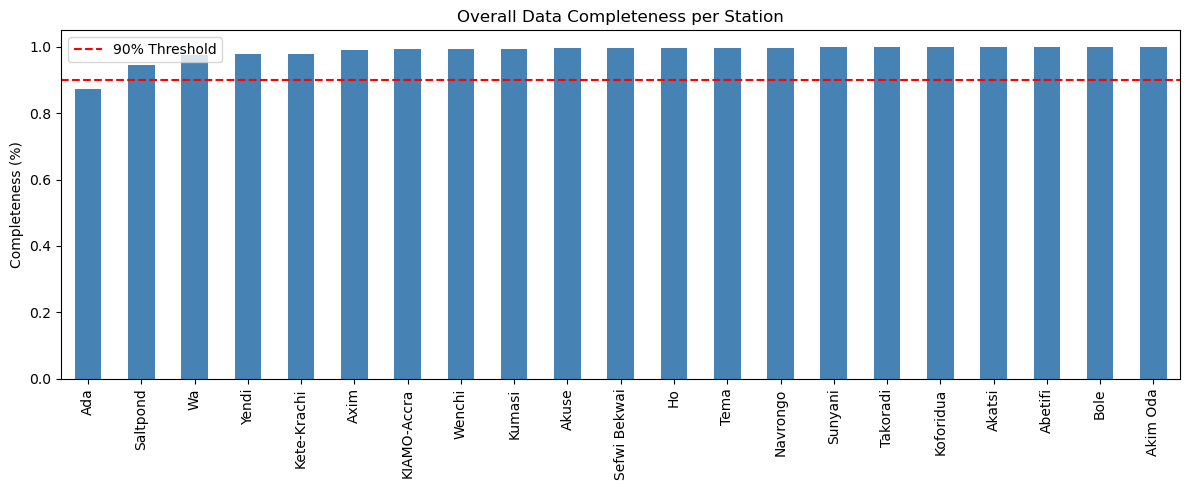

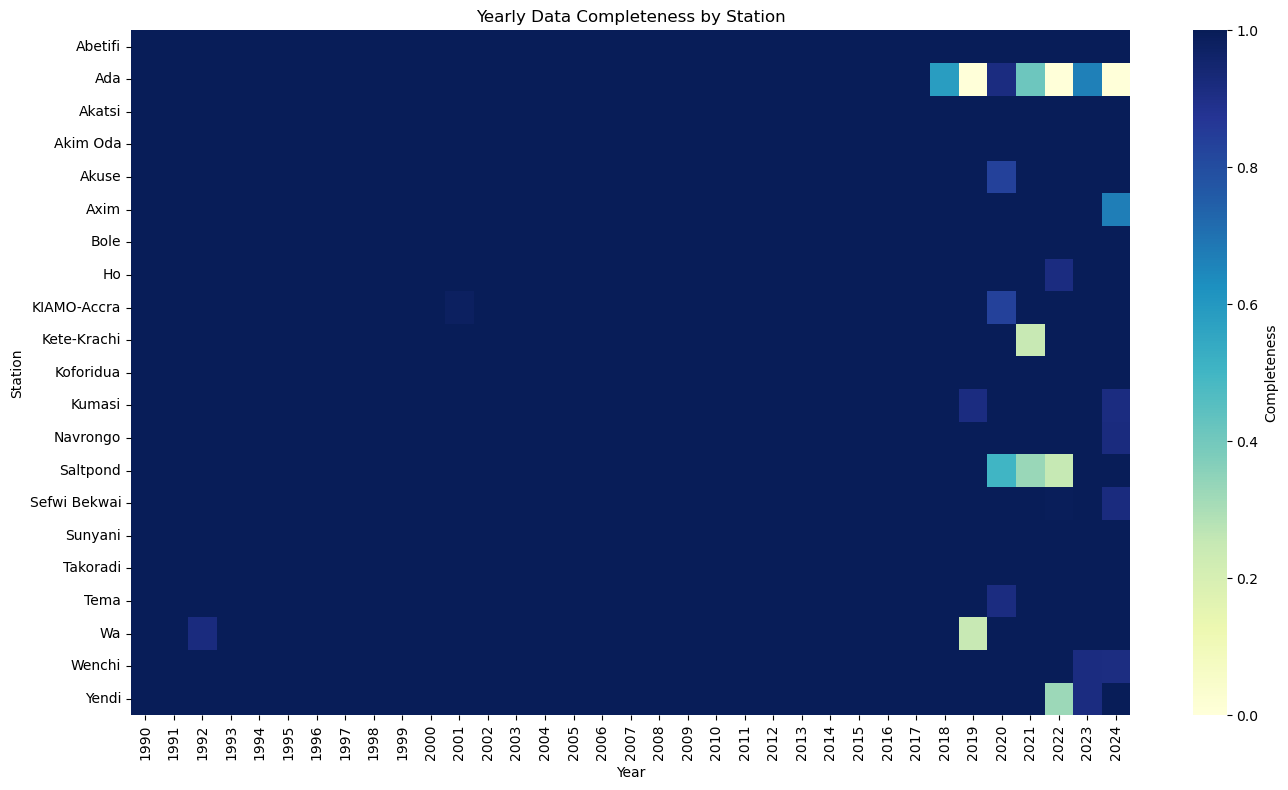

In [63]:


# ========= CONFIG =========
RAINFALL_FILE = "cleaned_parameters_v2/rainfall.csv"
MIN_COMPLETENESS = 0.9   # 90%
MAX_INTERPOLATE_GAP = 5  # max days to interpolate consecutively
# ==========================

# Load data
df = pd.read_csv(RAINFALL_FILE, parse_dates=["date"])
df = df.set_index("date")

# --- Step A: completeness per station (overall) ---
station_valid = df.notna().sum()
station_total = len(df)
station_completeness = station_valid / station_total

# --- Step A2: completeness per year ---
yearly_completeness = df.groupby(df.index.year).apply(
    lambda g: g.notna().sum() / len(g)
)

# --- Step B: flag stations ---
stations_to_keep = station_completeness[station_completeness >= MIN_COMPLETENESS].index.tolist()
stations_flagged = [s for s in df.columns if s not in stations_to_keep]

# --- Step C: imputation of small gaps ---
df_interp = df.copy()
for col in df_interp.columns:
    df_interp[col] = df_interp[col].interpolate(limit=MAX_INTERPOLATE_GAP, limit_direction='both')

df_interp[stations_flagged] = np.nan
df_interp.to_csv("rainfall_cleaned.csv")

# --- VISUAL CHECKS ---

# 1. Barplot of overall completeness
plt.figure(figsize=(12,5))
station_completeness.sort_values().plot(kind="bar", color="steelblue")
plt.axhline(MIN_COMPLETENESS, color="red", linestyle="--", label="90% Threshold")
plt.ylabel("Completeness (%)")
plt.title("Overall Data Completeness per Station")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Heatmap of yearly completeness
plt.figure(figsize=(14,8))
heatmap_data = yearly_completeness.T  # stations on rows
sns.heatmap(heatmap_data, cmap="YlGnBu", vmin=0, vmax=1, cbar_kws={'label': 'Completeness'})
plt.title("Yearly Data Completeness by Station")
plt.xlabel("Year")
plt.ylabel("Station")
plt.tight_layout()
plt.show()


# OBJECTIVE 1

In [64]:

# Load cleaned rainfall data
df = pd.read_csv("rainfall_cleaned.csv", parse_dates=["date"])
df = df.set_index("date")

# Drop Ada (excluded)
df = df.drop(columns=["Ada"], errors="ignore")

# ---- Step 1: thresholds (90th and 95th) per station ----
thresholds = {}
for col in df.columns:
    valid = df[col].dropna()
    thresholds[col] = {
        "p90": np.percentile(valid, 90),
        "p95": np.percentile(valid, 95)
    }

# ---- Step 2: tag extremes ----
extreme_90 = df.copy()
extreme_95 = df.copy()
for col in df.columns:
    extreme_90[col] = (df[col] > thresholds[col]["p90"]).astype(int)
    extreme_95[col] = (df[col] > thresholds[col]["p95"]).astype(int)

# Annual counts of extreme days
annual_counts_90 = extreme_90.resample("YE").sum()
annual_counts_95 = extreme_95.resample("YE").sum()

# RX1day: annual maximum 1-day rainfall
rx1day = df.resample("YE").max()

# RX5day: rolling 5-day sum, then take annual max
rolling5 = df.rolling(window=5).sum()
rx5day = rolling5.resample("YE").max()

# Save results
annual_counts_90.to_csv("annual_counts_p90.csv")
annual_counts_95.to_csv("annual_counts_p95.csv")
rx1day.to_csv("rx1day.csv")
rx5day.to_csv("rx5day.csv")

print("Computed annual extreme rainfall metrics:")
print(" - annual_counts_p90.csv")
print(" - annual_counts_p95.csv")
print(" - rx1day.csv")
print(" - rx5day.csv")


Computed annual extreme rainfall metrics:
 - annual_counts_p90.csv
 - annual_counts_p95.csv
 - rx1day.csv
 - rx5day.csv


In [65]:
# Load computed files
annual_counts_90 = pd.read_csv("annual_counts_p90.csv", index_col=0, parse_dates=True)
annual_counts_95 = pd.read_csv("annual_counts_p95.csv", index_col=0, parse_dates=True)
rx1day = pd.read_csv("rx1day.csv", index_col=0, parse_dates=True)
rx5day = pd.read_csv("rx5day.csv", index_col=0, parse_dates=True)

def mann_kendall_sen(df, label):
    results = []
    for col in df.columns:
        series = df[col].dropna()
        if len(series) < 10:  # skip if too few years
            continue
        try:
            test = mk.original_test(series.values)
            results.append({
                "Station": col,
                "Metric": label,
                "Trend": test.trend,              # 'increasing', 'decreasing', 'no trend'
                "p_value": test.p,
                "Sen_slope": test.slope
            })
        except Exception as e:
            print(f"Error for {col}: {e}")
    return pd.DataFrame(results)

# Apply tests
res_90 = mann_kendall_sen(annual_counts_90, "Annual Count >90th")
res_95 = mann_kendall_sen(annual_counts_95, "Annual Count >95th")
res_rx1 = mann_kendall_sen(rx1day, "RX1day")
res_rx5 = mann_kendall_sen(rx5day, "RX5day")

# Combine results
all_results = pd.concat([res_90, res_95, res_rx1, res_rx5], ignore_index=True)

# Save results
all_results.to_csv("trend_results.csv", index=False)

print("Trend analysis complete. Results saved to trend_results.csv")

Trend analysis complete. Results saved to trend_results.csv


In [66]:
# Load data
annual_counts_90 = pd.read_csv("annual_counts_p90.csv", index_col=0, parse_dates=True)
annual_counts_95 = pd.read_csv("annual_counts_p95.csv", index_col=0, parse_dates=True)
rx1day = pd.read_csv("rx1day.csv", index_col=0, parse_dates=True)
rx5day = pd.read_csv("rx5day.csv", index_col=0, parse_dates=True)
trend_results = pd.read_csv("trend_results.csv")

# Put metrics in dict for iteration
metrics = {
    "Annual Count >90th": annual_counts_90,
    "Annual Count >95th": annual_counts_95,
    "RX1day": rx1day,
    "RX5day": rx5day
}

# Make folder for plots
import os
os.makedirs("station_trend_plots", exist_ok=True)

for station in annual_counts_90.columns:   # loop through all stations
    plt.figure(figsize=(12,8))
    
    # Plot each metric as subplot
    for i, (label, df) in enumerate(metrics.items(), 1):
        series = df[station].dropna()
        if len(series) < 10:  # skip if too few years
            continue

        ax = plt.subplot(2,2,i)
        years = series.index.year
        ax.plot(years, series, marker='o', label=label, color="steelblue")

        # Add Sen’s slope line if significant
        row = trend_results[(trend_results["Station"] == station) & (trend_results["Metric"] == label)]
        if not row.empty and row.iloc[0]["p_value"] < 0.05:
            slope = row.iloc[0]["Sen_slope"]
            intercept = series.iloc[0] - slope * years[0]
            trendline = intercept + slope * years
            ax.plot(years, trendline, color="red", linestyle="--", label=f"Trend (p={row.iloc[0]['p_value']:.3f})")

        ax.set_title(label)
        ax.set_xlabel("Year")
        ax.set_ylabel("Value")
        ax.legend()

    plt.suptitle(f"Extreme Rainfall Trends at {station}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"station_trend_plots/{station}_trends.png", dpi=300)
    plt.close()

print("Saved all station trend plots in 'station_trend_plots/' folder")

Saved all station trend plots in 'station_trend_plots/' folder


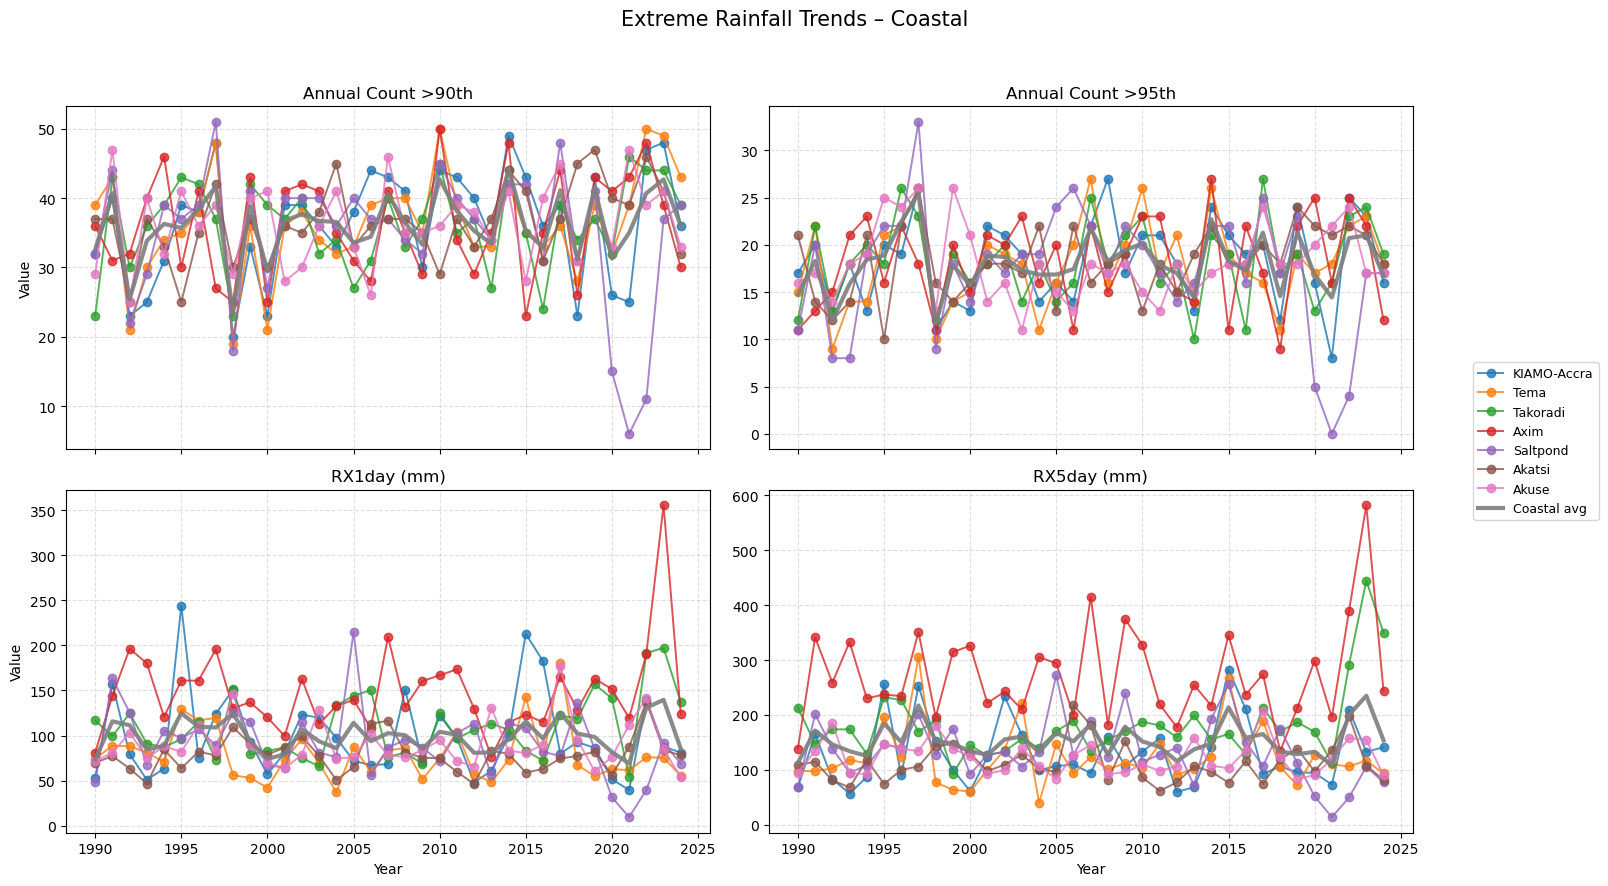

Saved zone_trends_Coastal.png


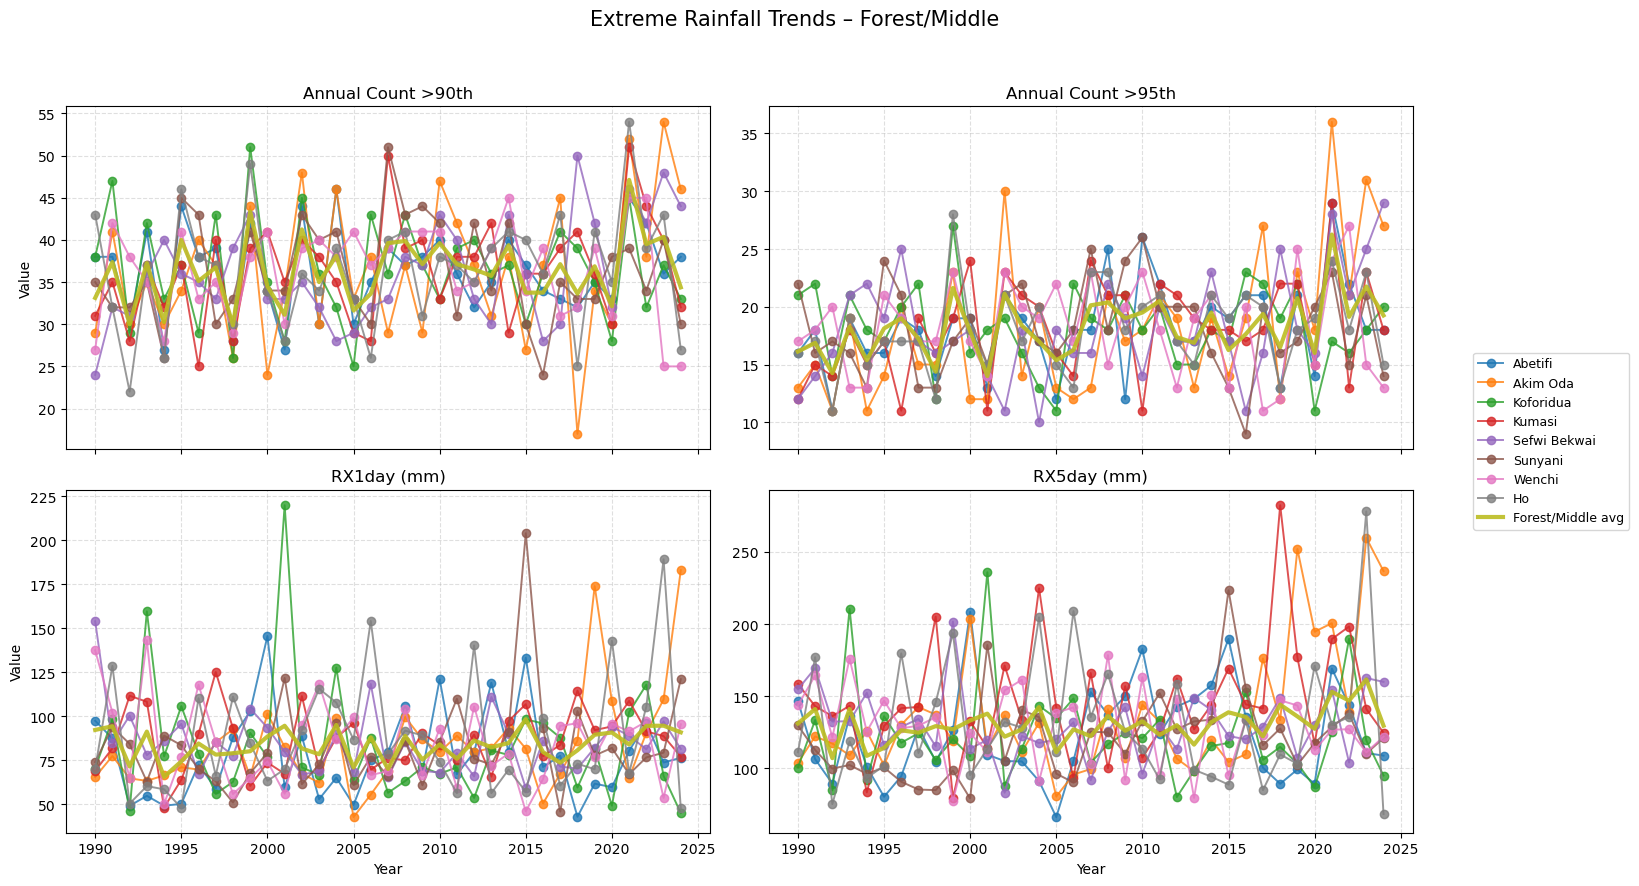

Saved zone_trends_Forest-Middle.png


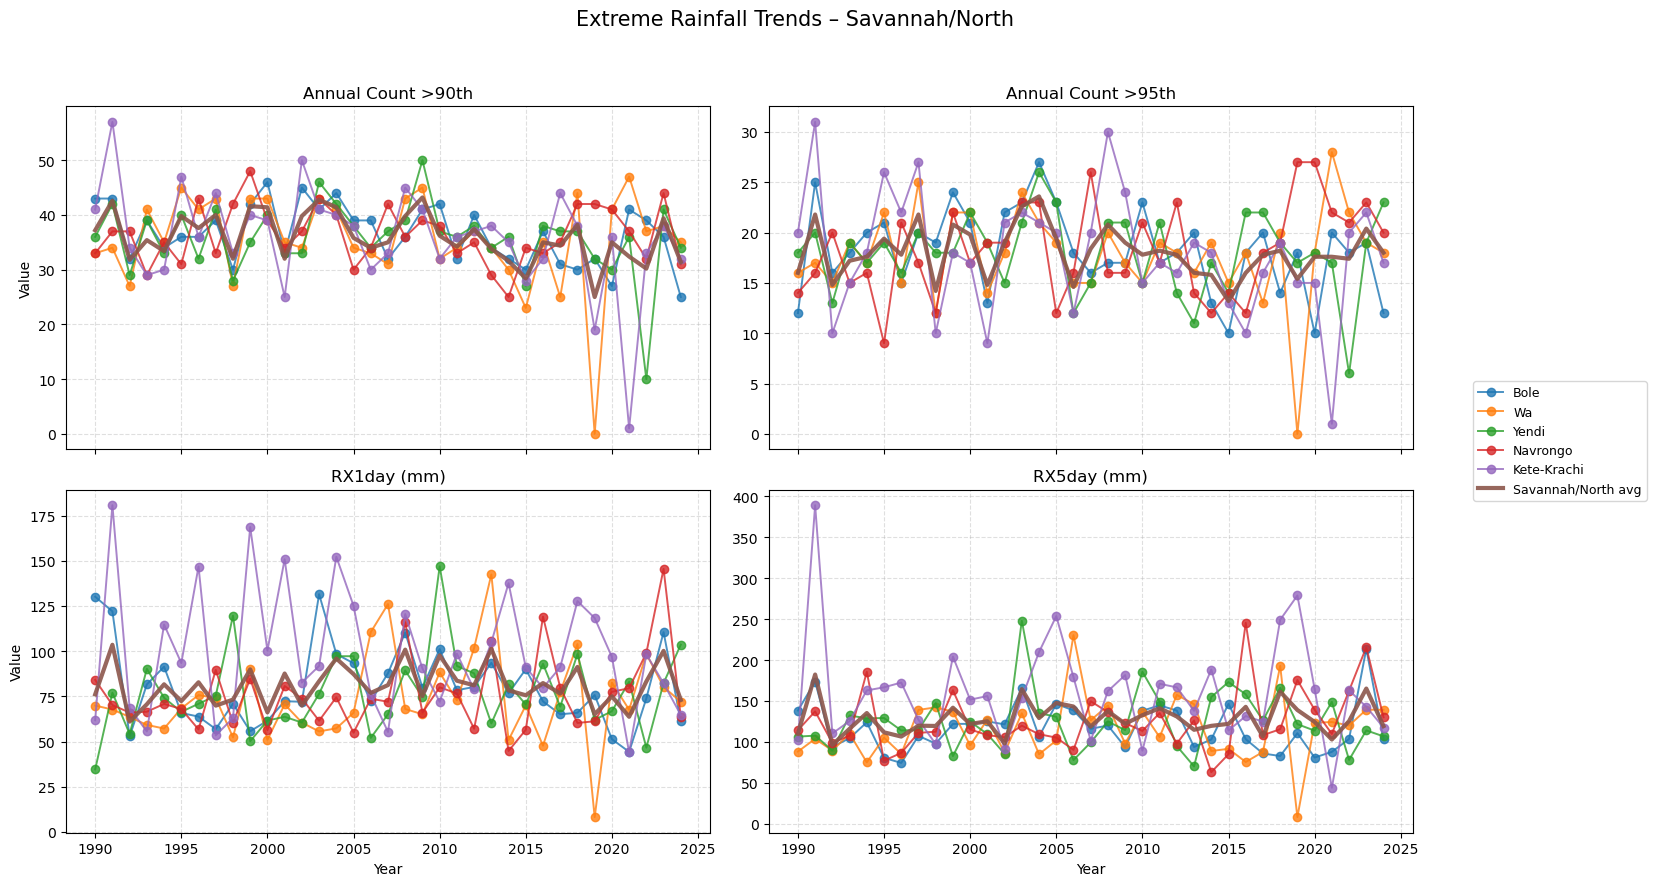

Saved zone_trends_Savannah-North.png


In [5]:


# ---- Load precomputed series ----
annual_counts_90 = pd.read_csv("annual_counts_p90.csv", index_col=0, parse_dates=True)
annual_counts_95 = pd.read_csv("annual_counts_p95.csv", index_col=0, parse_dates=True)
rx1day           = pd.read_csv("rx1day.csv",           index_col=0, parse_dates=True)
rx5day           = pd.read_csv("rx5day.csv",           index_col=0, parse_dates=True)

# If Ada was excluded earlier, nothing to drop; otherwise keep this:
for df in (annual_counts_90, annual_counts_95, rx1day, rx5day):
    df.drop(columns=["Ada"], errors="ignore", inplace=True)

# ---- Zone definitions (adjust if you prefer) ----
ZONES = {
    "Coastal": [
        "KIAMO-Accra", "Tema", "Takoradi", "Axim", "Saltpond",
        "Akatsi", "Akuse"
    ],
    "Forest/Middle": [
        "Abetifi", "Akim Oda", "Koforidua", "Kumasi",
        "Sefwi Bekwai", "Sunyani", "Wenchi", "Ho"
    ],
    "Savannah/North": [
        "Bole", "Tamale", "Wa", "Yendi", "Navrongo", "Kete-Krachi"
    ],
}

# ---- Helper to plot one zone with 4 panels ----
def plot_zone_panels(zone_name, stations, show_zone_mean=True, min_years=10):
    # Only keep stations present in dataframes
    stations = [s for s in stations if s in annual_counts_90.columns]

    # Collect metrics in a list of (title, dataframe)
    metrics = [
        ("Annual Count >90th", annual_counts_90),
        ("Annual Count >95th", annual_counts_95),
        ("RX1day (mm)",        rx1day),
        ("RX5day (mm)",        rx5day),
    ]

    fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex=True)
    axes = axes.ravel()

    for ax, (title, df) in zip(axes, metrics):
        # Plot each station series in this zone
        plotted = []
        for s in stations:
            series = df[s].dropna()
            if len(series) < min_years:
                continue
            years = series.index.year
            ax.plot(years, series.values, marker="o", linewidth=1.4, alpha=0.8, label=s)
            plotted.append(series)

        # Optional zone average (only if at least one station plotted)
        if show_zone_mean and len(plotted) > 0:
            # Align by index (year) before averaging
            zdf = pd.concat(plotted, axis=1)
            zmean = zdf.mean(axis=1)
            ax.plot(zmean.index.year, zmean.values, linewidth=3.0, alpha=0.9, label=f"{zone_name} avg")

        ax.set_title(title, fontsize=12)
        ax.grid(True, linestyle="--", alpha=0.4)

    # Common labels
    for ax in axes[2:]:
        ax.set_xlabel("Year")
    axes[0].set_ylabel("Value")
    axes[2].set_ylabel("Value")

    # Single legend outside (right)
    handles, labels = axes[0].get_legend_handles_labels()
    # Collect from other axes too (unique)
    for ax in axes[1:]:
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li not in labels:
                handles.append(hi); labels.append(li)

    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(0.92, 0.5), fontsize=9)
    fig.suptitle(f"Extreme Rainfall Trends – {zone_name}", fontsize=15)
    fig.tight_layout(rect=[0, 0, 0.90, 0.95])
    out = f"zone_trends_{zone_name.replace('/','-').replace(' ','_')}.png"
    plt.savefig(out, dpi=300)
    plt.show()
    print(f"Saved {out}")

# ---- Generate the three zone figures ----
for zone, stations in ZONES.items():
    plot_zone_panels(zone, stations, show_zone_mean=True)


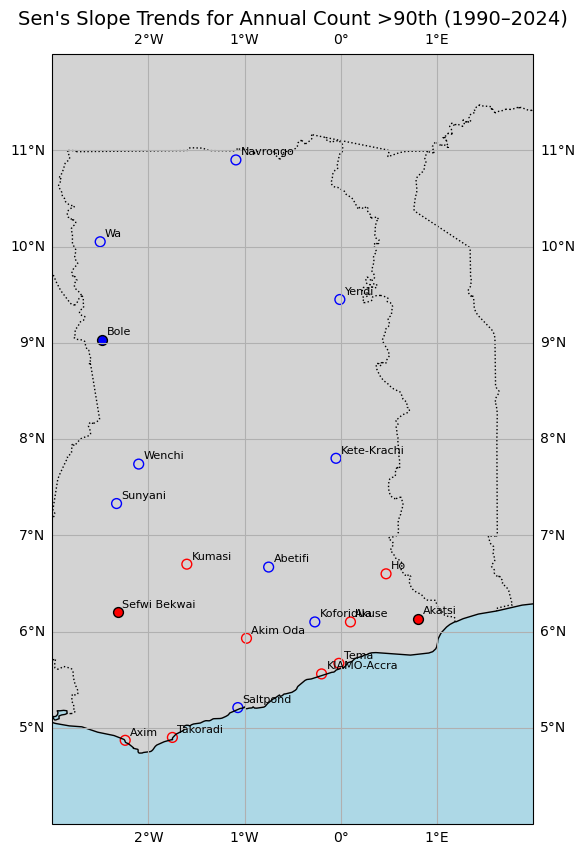

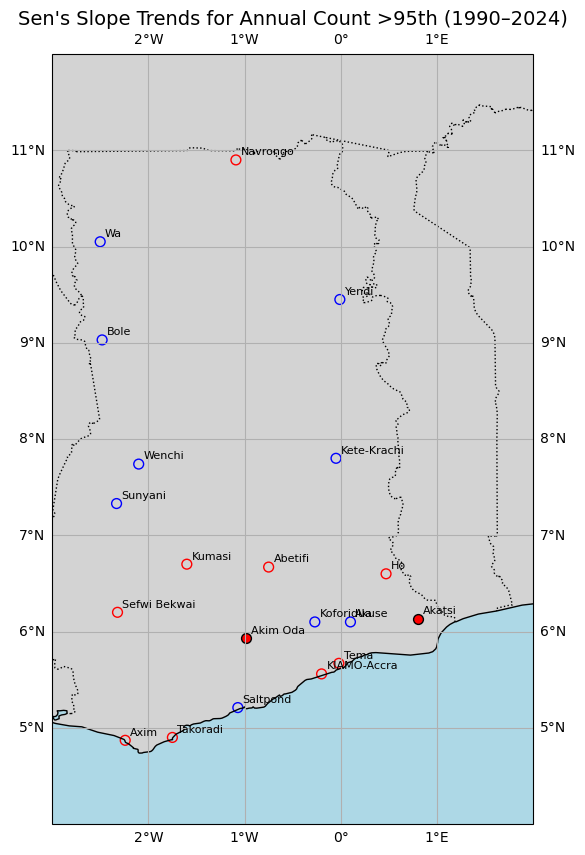

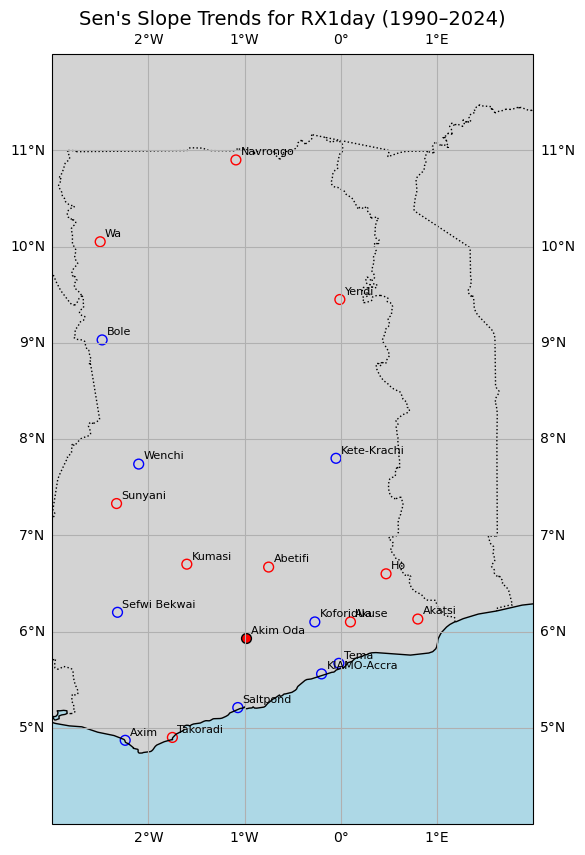

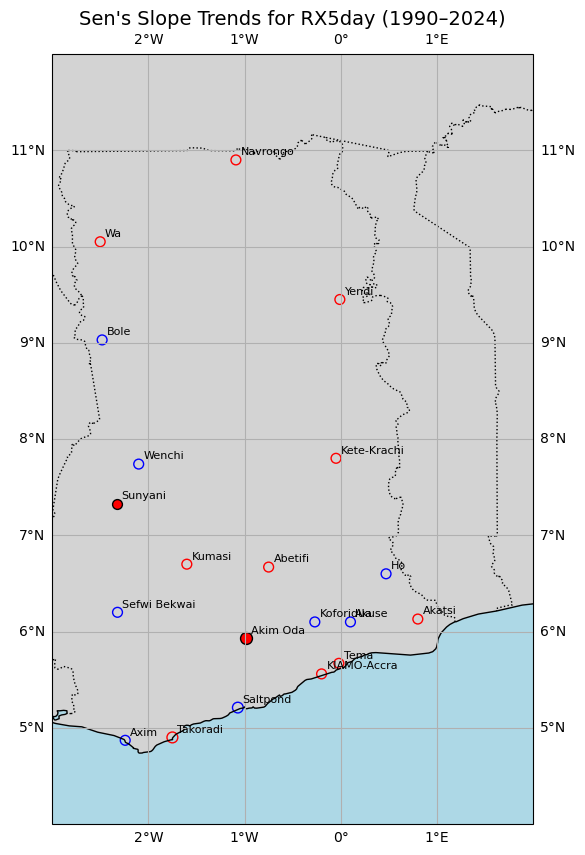

In [67]:
# Load trend results
trend_results = pd.read_csv("trend_results.csv")

# Station coordinates
station_coords = {
    "Abetifi": (6.67, -0.75),
    "Ada": (5.78, 0.62),
    "Akatsi": (6.13, 0.80),
    "Akim Oda": (5.93, -0.98),
    "Akuse": (6.10, 0.10),
    "Axim": (4.87, -2.24),
    "Bole": (9.03, -2.48),
    "Ho": (6.60, 0.47),
    "KIAMO-Accra": (5.56, -0.20),
    "Kete-Krachi": (7.80, -0.05),
    "Koforidua": (6.10, -0.27),
    "Kumasi": (6.70, -1.60),
    "Navrongo": (10.90, -1.09),
    "Saltpond": (5.21, -1.07),
    "Sefwi Bekwai": (6.20, -2.32),
    "Sunyani": (7.33, -2.33),
    "Takoradi": (4.90, -1.75),
    "Tamale": (9.40, -0.83),
    "Tema": (5.67, -0.02),
    "Wa": (10.05, -2.50),
    "Wenchi": (7.74, -2.10),
    "Yendi": (9.45, -0.01)
}

# Function to map Sen's slope
def plot_trend_map(metric):
    df = trend_results[trend_results["Metric"] == metric]
    
    plt.figure(figsize=(8,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-3, 2, 4, 12], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
    ax.gridlines(draw_labels=True)
    
    for _, row in df.iterrows():
        station = row["Station"]
        if station not in station_coords:
            continue
        lat, lon = station_coords[station]
        slope = row["Sen_slope"]
        pval = row["p_value"]
        
        # Marker size proportional to magnitude
        size = min(200, max(50, abs(slope)*50))
        # Color: red=increasing, blue=decreasing
        color = "red" if slope > 0 else "blue"
        # Shape: filled if significant (p<0.05), open if not
        if pval < 0.05:
            ax.scatter(lon, lat, s=size, c=color, edgecolor="k", marker="o", transform=ccrs.PlateCarree())
        else:
            ax.scatter(lon, lat, s=size, facecolors="none", edgecolor=color, marker="o", transform=ccrs.PlateCarree())
        
        ax.text(lon+0.05, lat+0.05, station, fontsize=8, transform=ccrs.PlateCarree())
    
    plt.title(f"Sen's Slope Trends for {metric} (1990–2024)", fontsize=14)
    metric_clean = re.sub(r"[ >{}]", "_", metric)
    plt.savefig(f"trend_map_{metric_clean}.png", dpi=300)
    plt.show()

# Plot for each metric
plot_trend_map("Annual Count >90th")
plot_trend_map("Annual Count >95th")
plot_trend_map("RX1day")
plot_trend_map("RX5day")

In [56]:
# # Function to plot all metrics in subplots
# def plot_trend_maps_subplots():
#     metrics = ["Annual Count >90th", "Annual Count >95th", "RX1day", "RX5day"]
#     fig, axes = plt.subplots(2, 2, figsize=(15, 15), subplot_kw={"projection": ccrs.PlateCarree()})
#     axes = axes.flatten()

#     for ax, metric in zip(axes, metrics):
#         df = trend_results[trend_results["Metric"] == metric]
        
#         ax.set_extent([-3, 2, 4, 12], crs=ccrs.PlateCarree())
#         ax.add_feature(cfeature.COASTLINE)
#         ax.add_feature(cfeature.BORDERS, linestyle=":")
#         ax.add_feature(cfeature.LAND, facecolor="lightgray")
#         ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
#         ax.gridlines(draw_labels=True)

#         for _, row in df.iterrows():
#             station = row["Station"]
#             if station not in station_coords:
#                 continue
#             lat, lon = station_coords[station]
#             slope = row["Sen_slope"]
#             pval = row["p_value"]

#             # Marker size proportional to magnitude
#             size = min(200, max(50, abs(slope)*50))
#             color = "red" if slope > 0 else "blue"

#             # Filled if significant, hollow otherwise
#             if pval < 0.05:
#                 ax.scatter(lon, lat, s=size, c=color, edgecolor="k", marker="o", transform=ccrs.PlateCarree())
#             else:
#                 ax.scatter(lon, lat, s=size, facecolors="none", edgecolor=color, marker="o", transform=ccrs.PlateCarree())
            
#             ax.text(lon+0.05, lat+0.05, station, fontsize=7, transform=ccrs.PlateCarree())

#         ax.set_title(f"{metric} (1990–2024)", fontsize=12)

#     plt.suptitle("Sen's Slope Trends for Extreme Rainfall Metrics", fontsize=16, y=0.92)
#     plt.tight_layout()
#     plt.savefig("trend_maps_subplots.png", dpi=300)
#     plt.show()

# # Run it
# plot_trend_maps_subplots()

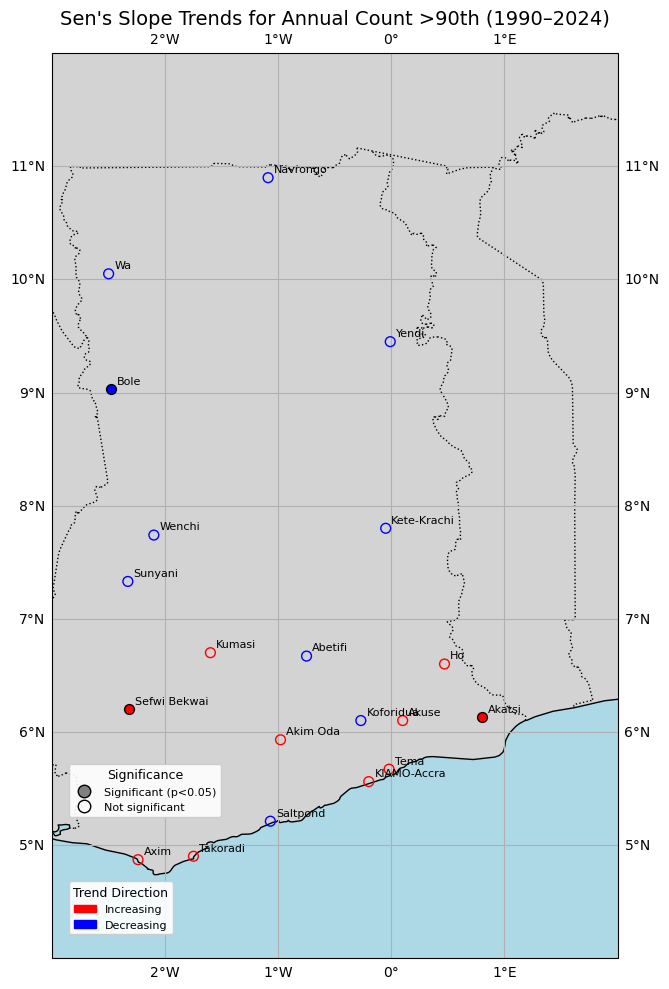

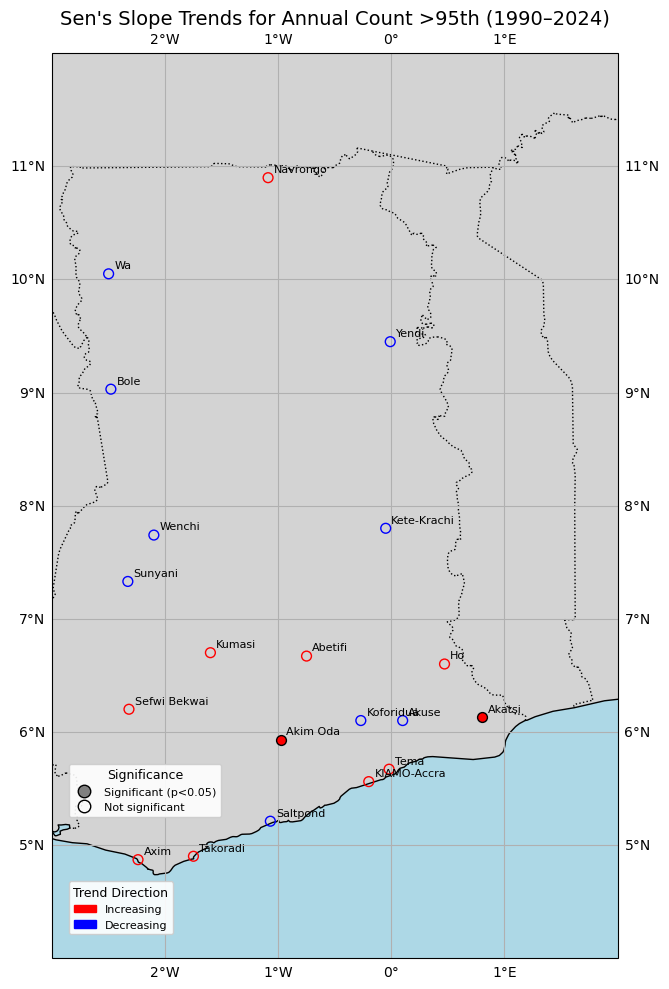

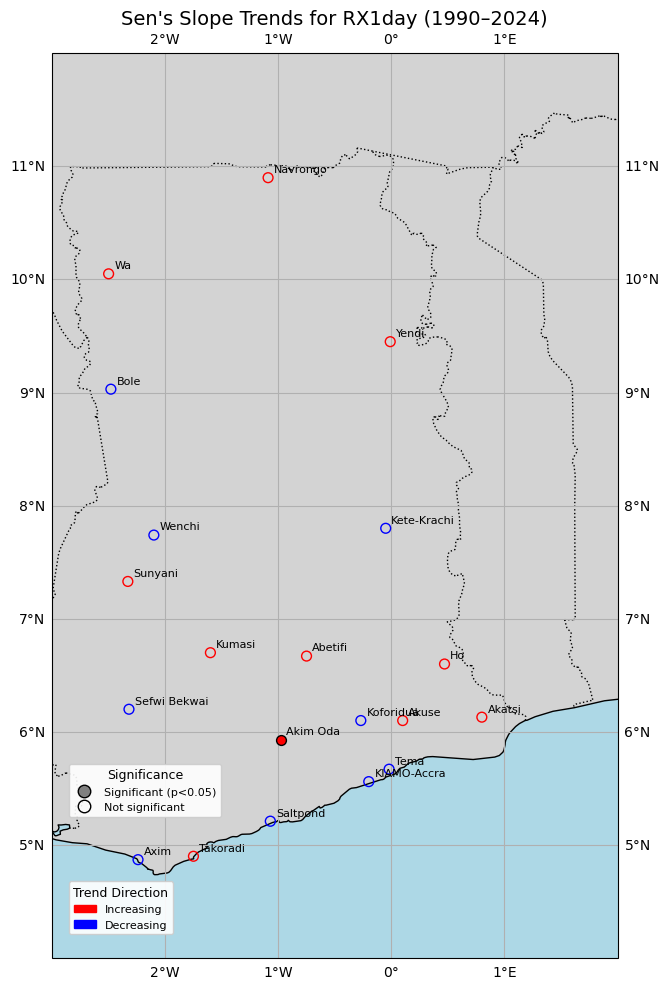

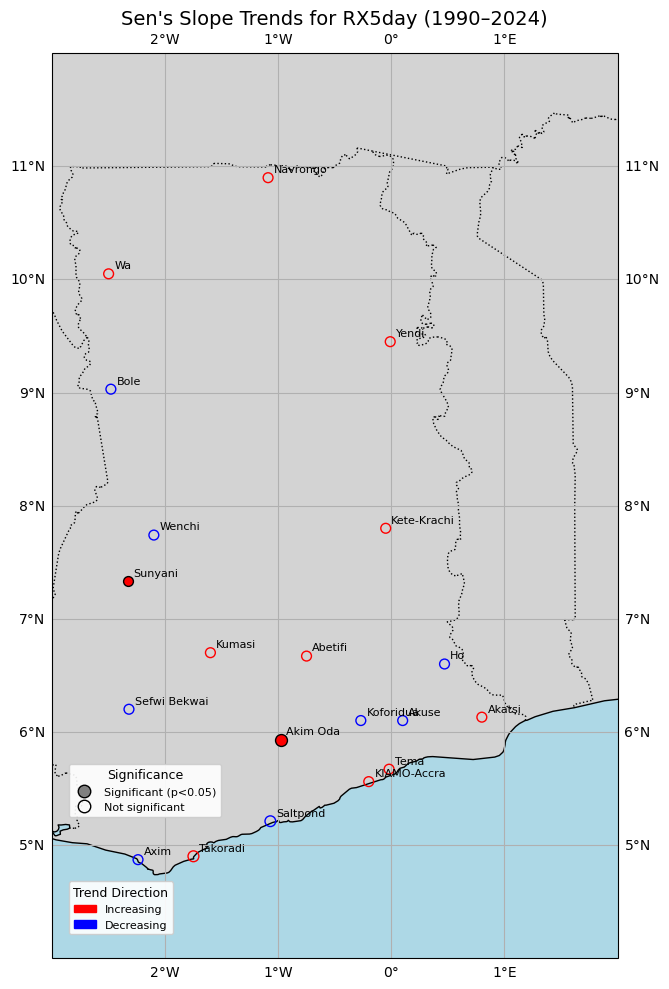

In [72]:
def plot_trend_map(metric):
    df = trend_results[trend_results["Metric"] == metric]
    
    fig = plt.figure(figsize=(8, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-3, 2, 4, 12], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, zorder=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=1)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", zorder=0)
    ax.gridlines(draw_labels=True)

    for _, row in df.iterrows():
        station = row["Station"]
        if station not in station_coords:
            continue
        lat, lon = station_coords[station]
        slope = row["Sen_slope"]
        pval  = row["p_value"]

        size  = min(200, max(50, abs(slope) * 50))
        color = "red" if slope > 0 else "blue"

        # significant = filled, not significant = hollow
        if pval < 0.05:
            ax.scatter(lon, lat, s=size, c=color, edgecolor="k", marker="o",
                       transform=ccrs.PlateCarree(), zorder=3)
        else:
            ax.scatter(lon, lat, s=size, facecolors="none", edgecolor=color, marker="o",
                       transform=ccrs.PlateCarree(), zorder=3)

        ax.text(lon + 0.05, lat + 0.05, station, fontsize=8,
                transform=ccrs.PlateCarree(), zorder=4)

    # ---- Legends: create two separate ones and anchor them on the map ----
    # Legend 1: Trend direction (color)
    color_handles = [
        Patch(color="red",  label="Increasing"),
        Patch(color="blue", label="Decreasing"),
    ]
    leg1 = ax.legend(handles=color_handles, title="Trend Direction",
                     loc="lower left", bbox_to_anchor=(0.02, 0.02),
                     frameon=True, framealpha=0.9, fontsize=8, title_fontsize=9)
    ax.add_artist(leg1)  # keep this legend when adding the next one

    # Legend 2: Significance (fill style)
    sig_handles = [
        Line2D([0], [0], marker='o', color='k', linestyle='None',
               markerfacecolor='gray', markersize=9, label='Significant (p<0.05)'),
        Line2D([0], [0], marker='o', color='k', linestyle='None',
               markerfacecolor='none', markersize=9, label='Not significant'),
    ]
    ax.legend(handles=sig_handles, title="Significance",
              loc="lower left", bbox_to_anchor=(0.02, 0.15),
              frameon=True, framealpha=0.9, fontsize=8, title_fontsize=9)

    plt.title(f"Sen's Slope Trends for {metric} (1990–2024)", fontsize=14)
    metric_clean = re.sub(r"[ >{}]", "_", metric)
    plt.tight_layout()
    plt.savefig(f"trend_map_{metric_clean}_with_legend.png", dpi=300)
    plt.show()

plot_trend_map("Annual Count >90th")
plot_trend_map("Annual Count >95th")
plot_trend_map("RX1day")
plot_trend_map("RX5day")

C:\Users\Annorion\AppData\Local\Temp\ipykernel_13212\1005482321.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Decade", y="ExtremeDays", data=df_melt, palette="Set2")


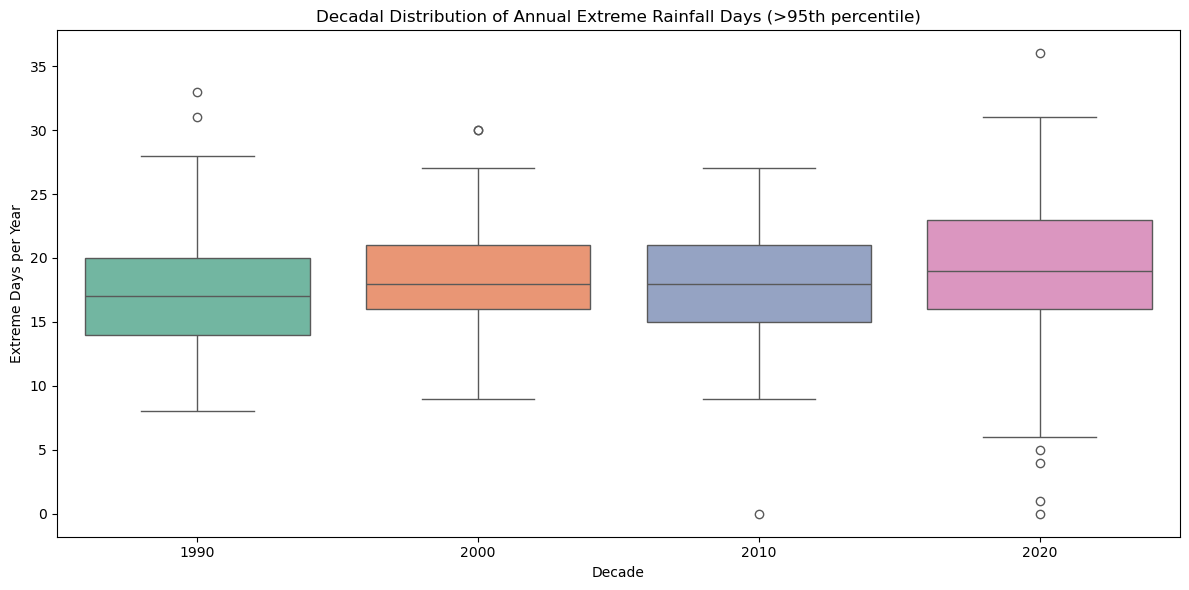

In [107]:
# Load annual counts (95th percentile extremes, as example)
annual_counts_95 = pd.read_csv("annual_counts_p95.csv", index_col=0, parse_dates=True)

# Add decade column
df_box = annual_counts_95.copy()
df_box["Decade"] = (df_box.index.year // 10) * 10

# Melt for seaborn
df_melt = df_box.melt(id_vars="Decade", var_name="Station", value_name="ExtremeDays")

plt.figure(figsize=(12,6))
sns.boxplot(x="Decade", y="ExtremeDays", data=df_melt, palette="Set2")
plt.title("Decadal Distribution of Annual Extreme Rainfall Days (>95th percentile)")
plt.ylabel("Extreme Days per Year")
plt.xlabel("Decade")
plt.tight_layout()
plt.savefig("boxplot_decadal_extremes.png", dpi=300)
plt.show()

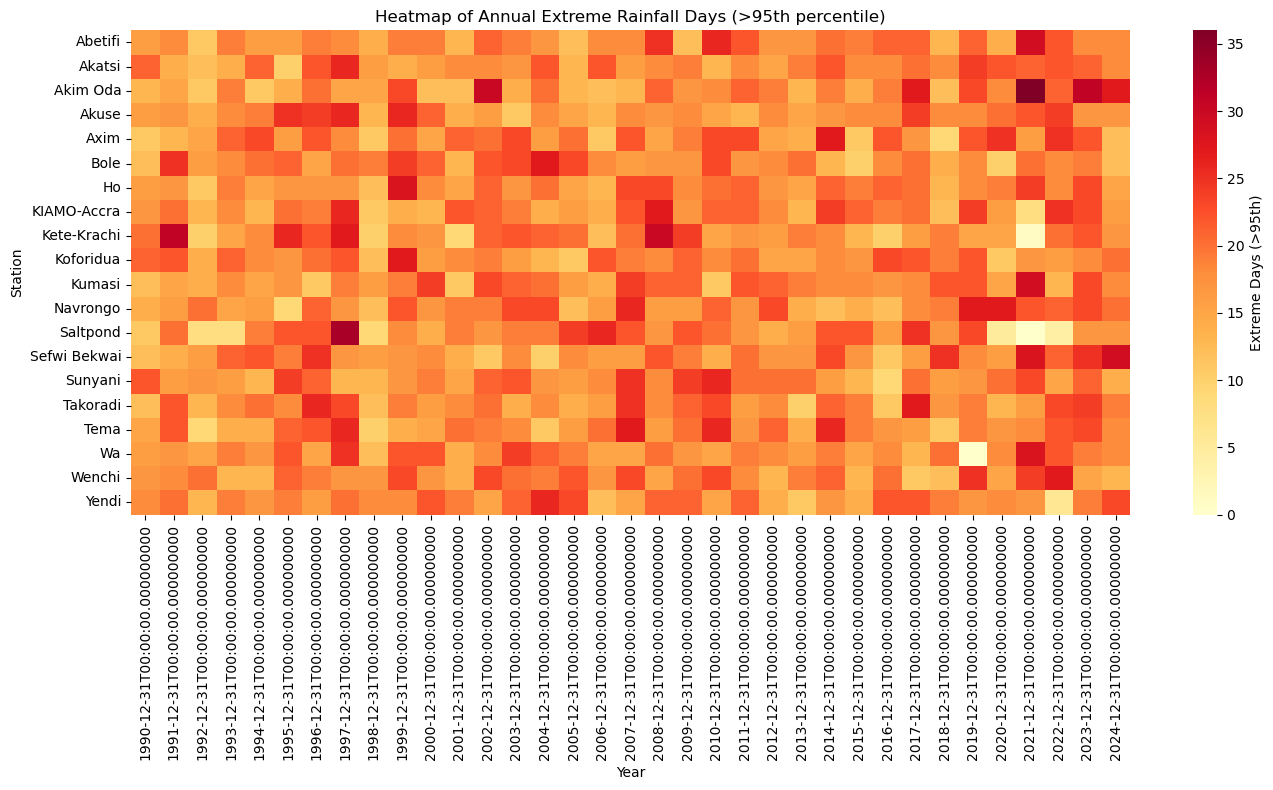

In [74]:
# Use annual_counts_95 for heatmap
heatmap_data = annual_counts_95.T  # transpose: stations as rows
heatmap_data.index.name = "Station"

plt.figure(figsize=(14,8))
sns.heatmap(heatmap_data, cmap="YlOrRd", cbar_kws={"label": "Extreme Days (>95th)"})
plt.title("Heatmap of Annual Extreme Rainfall Days (>95th percentile)")
plt.xlabel("Year")
plt.ylabel("Station")
plt.tight_layout()
plt.savefig("heatmap_extremes.png", dpi=300)
plt.show()

In [78]:
# Load RX1day data
rx1day = pd.read_csv("rx1day.csv", index_col=0, parse_dates=True)

# Make output folder
os.makedirs("return_period_curves", exist_ok=True)

# Define return periods of interest
T = np.array([2, 5, 10, 20, 50])  # years

for station in rx1day.columns:
    data = rx1day[station].dropna().values
    
    # Skip if insufficient data (<10 years of annual maxima)
    if len(data) < 10:
        print(f"Skipping {station} (not enough data)")
        continue
    
    try:
        # Fit Gumbel distribution
        loc, scale = gumbel_r.fit(data)
        
        # Compute return levels
        return_levels = gumbel_r.ppf(1 - 1/T, loc=loc, scale=scale)
        
        # Plot
        plt.figure(figsize=(8,6))
        plt.plot(T, return_levels, marker="o", color="steelblue", label=station)
        plt.xscale("log")
        plt.xlabel("Return Period (years, log scale)")
        plt.ylabel("Rainfall (mm)")
        plt.title(f"Return Period Curve for RX1day - {station}")
        plt.grid(True, which="both", linestyle="--")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"return_period_curves/{station}_return_period.png", dpi=300)
        plt.close()
        
        print(f"Saved return period curve for {station}")
        
    except Exception as e:
        print(f"Error fitting {station}: {e}")

Saved return period curve for Abetifi
Saved return period curve for Akatsi
Saved return period curve for Akim Oda
Saved return period curve for Akuse
Saved return period curve for Axim
Saved return period curve for Bole
Saved return period curve for Ho
Saved return period curve for KIAMO-Accra
Saved return period curve for Kete-Krachi
Saved return period curve for Koforidua
Saved return period curve for Kumasi
Saved return period curve for Navrongo
Saved return period curve for Saltpond
Saved return period curve for Sefwi Bekwai
Saved return period curve for Sunyani
Saved return period curve for Takoradi
Saved return period curve for Tema
Saved return period curve for Wa
Saved return period curve for Wenchi
Saved return period curve for Yendi


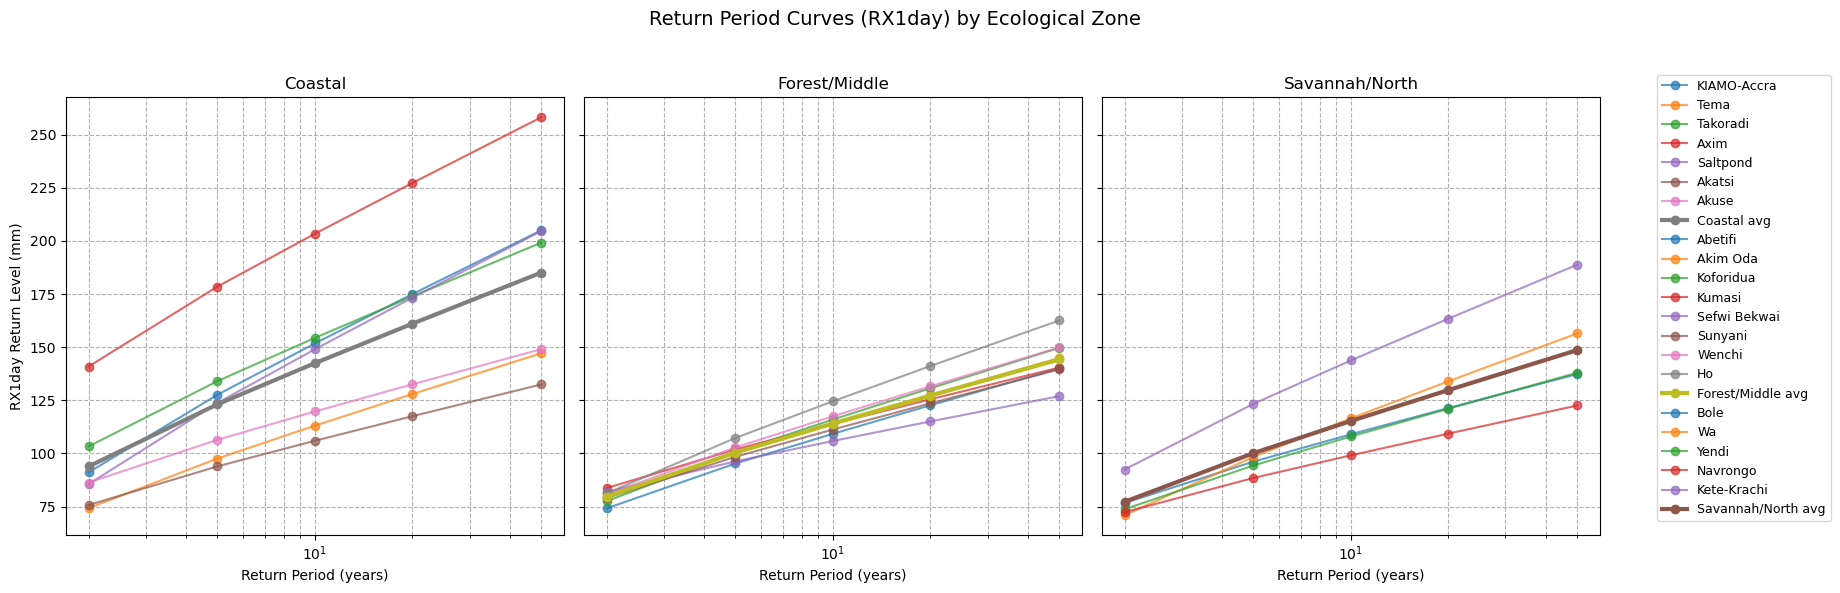

In [105]:


# ---------------- Config ----------------
RX1DAY_CSV = "rx1day.csv"
T = np.array([2, 5, 10, 20, 50])  # return periods (years)

# Map stations to ecological zones (tweak if you prefer different groupings)
ZONES = {
    "Coastal": [
        "KIAMO-Accra", "Tema", "Takoradi", "Axim", "Saltpond",
        # near-coastal / lower Volta (treat as coastal-transitional)
        "Akatsi", "Akuse"
    ],
    "Forest/Middle": [
        "Abetifi", "Akim Oda", "Koforidua", "Kumasi",
        "Sefwi Bekwai", "Sunyani", "Wenchi", "Ho"
    ],
    "Savannah/North": [
        "Bole", "Tamale", "Wa", "Yendi", "Navrongo", "Kete-Krachi"
    ],
}

# If you want to only include a subset, set this; otherwise we’ll include all found in the CSV
stations_whitelist = [
    "Abetifi", "Akatsi", "Akim Oda", "Akuse", "Axim", "Bole", "Ho", "KIAMO-Accra",
    "Kete-Krachi", "Koforidua", "Kumasi", "Navrongo", "Saltpond", "Sefwi Bekwai",
    "Sunyani", "Takoradi", "Tema", "Wa", "Wenchi", "Yendi"
]
# ----------------------------------------

# Load RX1day (annual maxima)
rx1day = pd.read_csv(RX1DAY_CSV, index_col=0, parse_dates=True)

# Keep only whitelisted stations that exist in the file
available_stations = [s for s in stations_whitelist if s in rx1day.columns]

# Helper: fit Gumbel and return curve (np.nan if not enough data)
def fit_gumbel_curve(values, T):
    values = pd.Series(values).dropna().values
    if len(values) < 10:   # need enough years of annual maxima
        return None
    try:
        loc, scale = gumbel_r.fit(values)
        return gumbel_r.ppf(1 - 1/T, loc=loc, scale=scale)
    except Exception:
        return None

# Prepare figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
zone_names = list(ZONES.keys())

for ax, zone in zip(axes, zone_names):
    # stations belonging to this zone and present in data
    stations_in_zone = [s for s in ZONES[zone] if s in available_stations]

    # collect curves for zone mean
    zone_curves = []

    for s in stations_in_zone:
        curve = fit_gumbel_curve(rx1day[s], T)
        if curve is None:
            print(f"Skipping {s} in {zone}: insufficient data or fit failed")
            continue
        zone_curves.append(curve)
        ax.plot(T, curve, marker="o", label=s, alpha=0.7)

    # Zone-average curve (if at least one station plotted)
    if len(zone_curves) > 0:
        zone_mean = np.nanmean(np.vstack(zone_curves), axis=0)
        ax.plot(T, zone_mean, marker="o", linewidth=3.0, label=f"{zone} avg", zorder=5)

    ax.set_title(zone)
    ax.set_xscale("log")
    ax.grid(True, which="both", linestyle="--")
    ax.set_xlabel("Return Period (years)")

# Common y-label & overall title
axes[0].set_ylabel("RX1day Return Level (mm)")
fig.suptitle("Return Period Curves (RX1day) by Ecological Zone", fontsize=14)

# A single legend outside (right)
handles, labels = axes[0].get_legend_handles_labels()
# extend with others (unique labels)
for ax in axes[1:]:
    h, l = ax.get_legend_handles_labels()
    for hi, li in zip(h, l):
        if li not in labels:
            handles.append(hi); labels.append(li)

fig.legend(handles, labels, loc="center left", bbox_to_anchor=(0.92, 0.5), fontsize=9)
fig.tight_layout(rect=[0, 0, 0.90, 0.95])   # leave room for right-side legend
plt.savefig("return_period_by_zone_subplots.png", dpi=300)
plt.show()


# OBJECTIVE 2

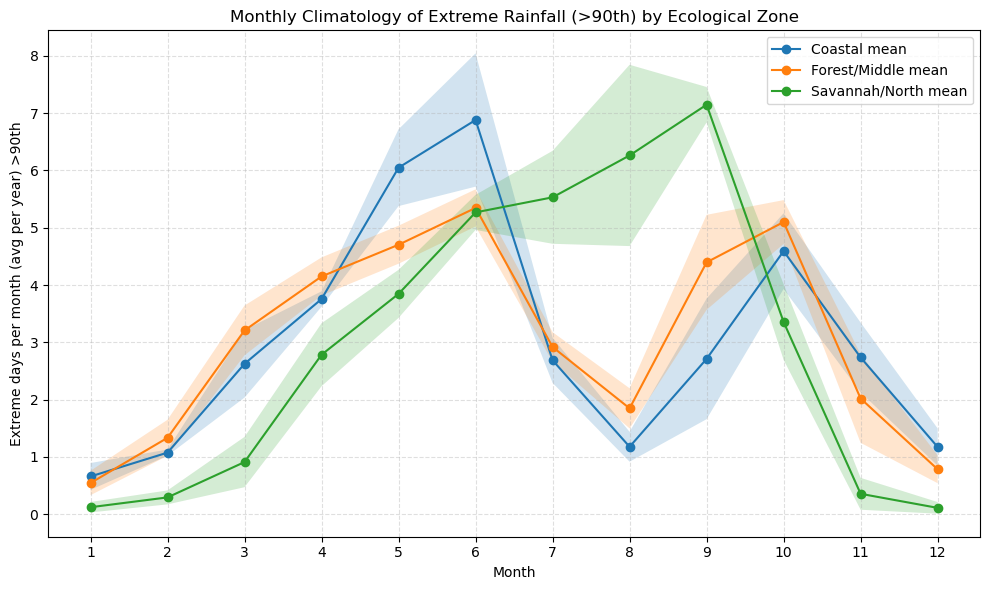

Abetifi: 11.90 mm
Akatsi: 6.77 mm
Akim Oda: 14.00 mm
Akuse: 7.78 mm
Axim: 14.90 mm
Bole: 8.90 mm
Ho: 11.20 mm
KIAMO-Accra: 3.40 mm
Kete-Krachi: 10.62 mm
Koforidua: 11.20 mm
Kumasi: 12.40 mm
Navrongo: 7.40 mm
Saltpond: 5.27 mm
Sefwi Bekwai: 14.00 mm
Sunyani: 10.60 mm
Takoradi: 7.40 mm
Tema: 2.60 mm
Wa: 9.20 mm
Wenchi: 11.10 mm
Yendi: 10.80 mm
National 95th percentile threshold: 9.70 mm


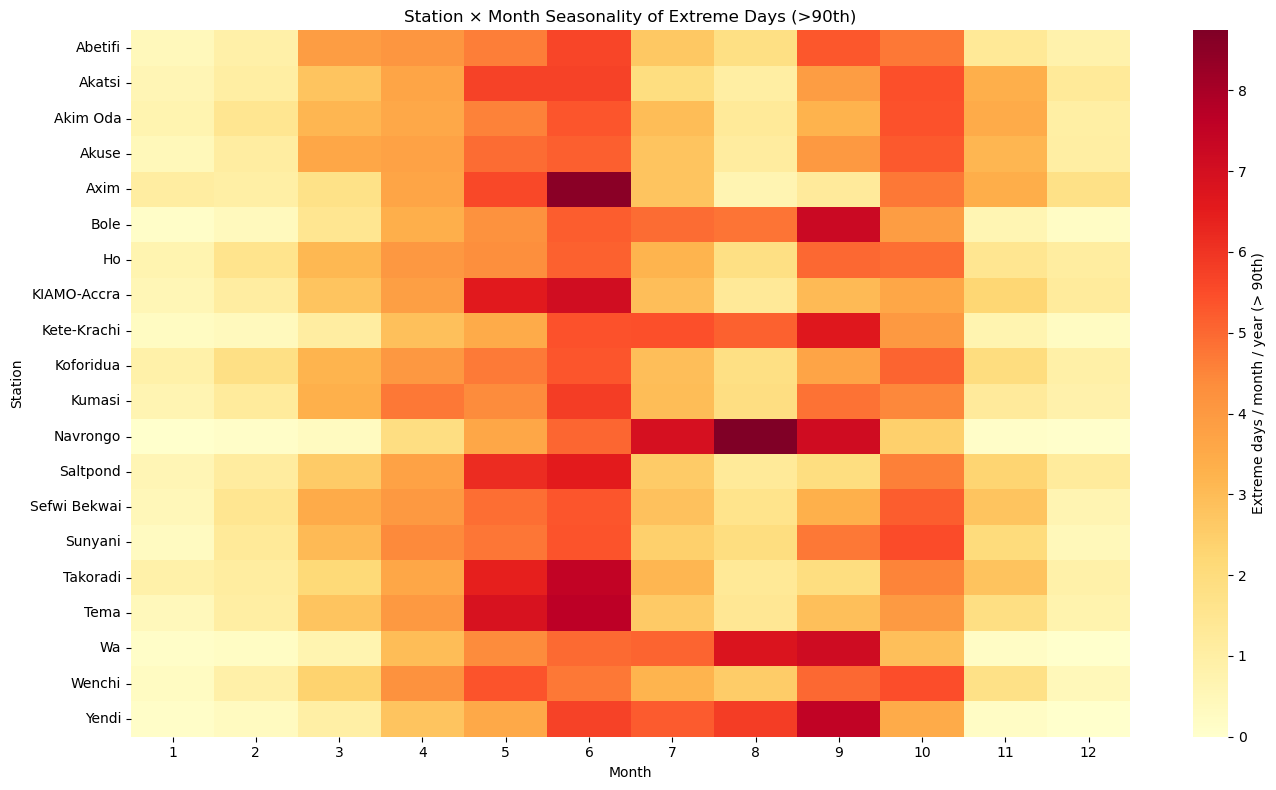

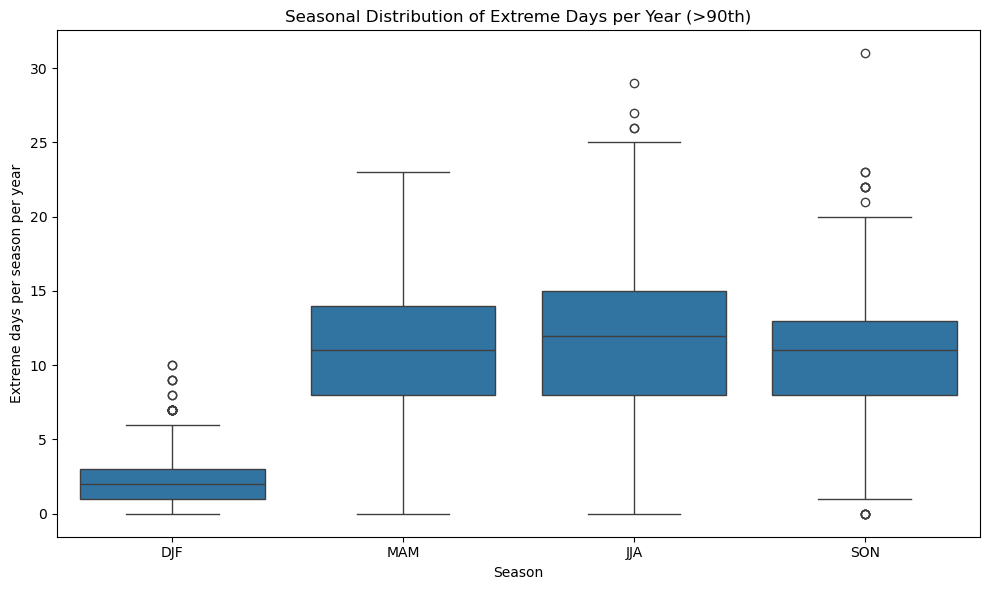

In [4]:
# ---------------- Config ----------------
RAIN_CSV = "rainfall_cleaned.csv"  # from Objective 1 pre-cleaning (Ada excluded or all-NaN)
PCTL = 90                          # percentile threshold for extremes (use 90 for sensitivity test)
ZONES = {
    "Coastal": [
        "KIAMO-Accra", "Tema", "Takoradi", "Axim", "Saltpond",
        "Akatsi", "Akuse"
    ],
    "Forest/Middle": [
        "Abetifi", "Akim Oda", "Koforidua", "Kumasi",
        "Sefwi Bekwai", "Sunyani", "Wenchi", "Ho"
    ],
    "Savannah/North": [
        "Bole", "Tamale", "Wa", "Yendi", "Navrongo", "Kete-Krachi"
    ],
}
SEASON_MAP = {12:"DJF",1:"DJF",2:"DJF", 3:"MAM",4:"MAM",5:"MAM",
              6:"JJA",7:"JJA",8:"JJA", 9:"SON",10:"SON",11:"SON"}
# ---------------------------------------

# Load rainfall
rf = pd.read_csv(RAIN_CSV, parse_dates=["date"]).set_index("date").sort_index()

# (Optional) ensure Ada is out:
rf = rf.drop(columns=["Ada"], errors="ignore")

# Compute per-station thresholds
thresholds = {c: np.nanpercentile(rf[c].values, PCTL) for c in rf.columns}

# Extreme flags (1/0)
ex = rf.copy()
for c in ex.columns:
    ex[c] = (rf[c] > thresholds[c]).astype(int)

# Convenience columns
years = rf.index.year
months = rf.index.month
n_years = years.nunique()

# ---------------- 1) Monthly climatology by Zone ----------------
# Average number of extreme days per month (per year) for each station
monthly_counts = ex.groupby(months).sum() / n_years   # shape (12, stations)
monthly_counts.index.name = "Month"

# Zone means & spread
zone_monthly = {}
for zone, stations in ZONES.items():
    cols = [s for s in stations if s in monthly_counts.columns]
    if not cols:
        continue
    zone_df = monthly_counts[cols]
    zone_monthly[zone] = {
        "mean": zone_df.mean(axis=1),
        "std":  zone_df.std(axis=1),
        "min":  zone_df.min(axis=1),
        "max":  zone_df.max(axis=1),
    }

# Plot: zone monthly climatology with ±1 std shading
plt.figure(figsize=(10,6))
for zone, d in zone_monthly.items():
    m = d["mean"]; s = d["std"]
    x = m.index.values
    plt.plot(x, m.values, marker='o', label=f"{zone} mean")
    plt.fill_between(x, (m - s).clip(lower=0), m + s, alpha=0.2)

plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel(f"Extreme days per month (avg per year) >{PCTL}th")
plt.title(f"Monthly Climatology of Extreme Rainfall (>{PCTL}th) by Ecological Zone")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig(f"seasonality_zone_monthly_p{PCTL}.png", dpi=300)
plt.show()
for station, thr in thresholds.items():
    print(f"{station}: {thr:.2f} mm")

# Flatten all daily rainfall values from all stations into one array
all_values = rf.values.flatten()
all_values = all_values[~np.isnan(all_values)]

threshold_90 = np.nanpercentile(all_values, 90)
print(f"National 95th percentile threshold: {threshold_90:.2f} mm")


# ---------------- 2) Station × Month heatmap ----------------
# Average extreme days per month per station (per year)
heat = monthly_counts.T  # stations as rows, months as columns
plt.figure(figsize=(14,8))
sns.heatmap(heat, cmap="YlOrRd", cbar_kws={"label": f"Extreme days / month / year (> {PCTL}th)"})
plt.xlabel("Month")
plt.ylabel("Station")
plt.title(f"Station × Month Seasonality of Extreme Days (>{PCTL}th)")
plt.tight_layout()
plt.savefig(f"seasonality_heatmap_station_month_p{PCTL}.png", dpi=300)
plt.show()

# ---------------- 3) Seasonal boxplots across years ----------------
# Build per-year seasonal counts per station
df_long = ex.copy()
df_long["Year"] = df_long.index.year
df_long["Month"] = df_long.index.month
df_long["Season"] = df_long["Month"].map(SEASON_MAP)

# sum extreme days per (Year, Season, Station)
season_counts = (
    df_long
    .drop(columns=["Month"])  # keep Year, Season + stations
    .groupby(["Year","Season"])
    .sum()
    .reset_index()
)

# Melt for seaborn
melt = season_counts.melt(id_vars=["Year","Season"], var_name="Station", value_name="ExtremeDays")

plt.figure(figsize=(10,6))
sns.boxplot(data=melt, x="Season", y="ExtremeDays", order=["DJF","MAM","JJA","SON"])
plt.title(f"Seasonal Distribution of Extreme Days per Year (>{PCTL}th)")
plt.ylabel("Extreme days per season per year")
plt.xlabel("Season")
plt.tight_layout()
plt.savefig(f"seasonality_boxplots_p{PCTL}.png", dpi=300)
plt.show()

# OBJECTIVES 3

Merged shape: (420, 5)
   ExtremeDays       ym  Anomaly    Phase       date
0            1  1990-01     0.01  Neutral 1990-01-31
1            8  1990-02     0.21  Neutral 1990-02-28
2            8  1990-03     0.04  Neutral 1990-03-31
3           55  1990-04     0.08  Neutral 1990-04-30
4           40  1990-05     0.08  Neutral 1990-05-31
Correlation ENSO lag0 vs ExtremeDays: r=-0.020, p=0.683
Correlation ENSO lag1 vs ExtremeDays: r=-0.044, p=0.369
Correlation ENSO lag2 vs ExtremeDays: r=-0.053, p=0.279


C:\Users\Annorion\AppData\Local\Temp\ipykernel_13212\764603633.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comp.reset_index(), x="Phase", y="mean",


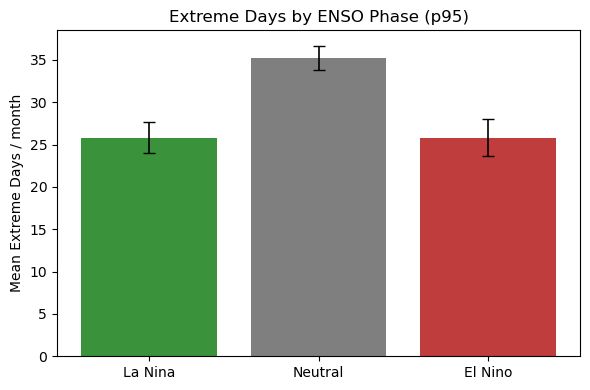

C:\Users\Annorion\AppData\Local\Temp\ipykernel_13212\764603633.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=enso_ext, x="Phase", y="ExtremeDays",


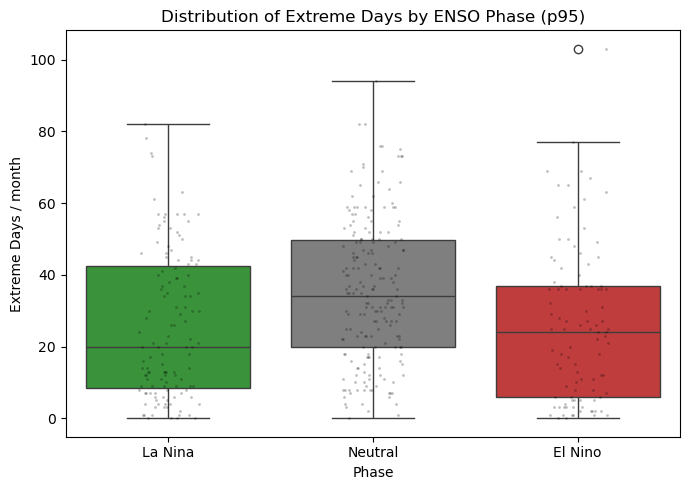

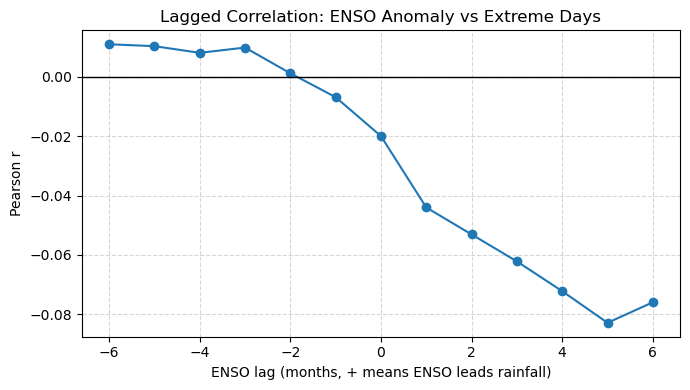

In [104]:
# ---------- Load ENSO ----------
enso = pd.read_csv("NINO 3.4.csv", header=None,
                   names=["Year", "Month", "SST", "Anomaly"])
enso["date"] = pd.to_datetime(dict(year=enso.Year, month=enso.Month, day=1))

def classify_phase(x):
    if x >= 0.5: return "El Nino"
    elif x <= -0.5: return "La Nina"
    else: return "Neutral"
enso["Phase"] = enso["Anomaly"].apply(classify_phase)

# Period key (monthly) for robust merging
enso["ym"] = enso["date"].dt.to_period("M")

# ---------- Build monthly extremes (95th pctl example) ----------
rf = pd.read_csv("rainfall_cleaned.csv", parse_dates=["date"]).set_index("date").sort_index()
# (optional) drop Ada if present and excluded
rf = rf.drop(columns=["Ada"], errors="ignore")

thresholds = {c: rf[c].dropna().quantile(0.95) for c in rf.columns}
ex = rf.copy()
for c in ex.columns:
    ex[c] = (rf[c] > thresholds[c]).astype(int)

monthly_extremes = ex.resample("ME").sum().sum(axis=1).to_frame("ExtremeDays")
monthly_extremes["ym"] = monthly_extremes.index.to_period("M")

# ---------- Merge on monthly period key ----------
enso_ext = monthly_extremes.merge(
    enso[["ym","Anomaly","Phase"]],
    on="ym", how="inner"
)

# (optional) convert back to timestamp (month-end) for plotting
enso_ext["date"] = enso_ext["ym"].dt.to_timestamp("M")

print("Merged shape:", enso_ext.shape)
print(enso_ext.head())

# ---------- Add ENSO lags (1 and 2 months) ----------
enso_ext = enso_ext.sort_values("date").reset_index(drop=True)
enso_ext["Anom_lag1"] = enso_ext["Anomaly"].shift(1)
enso_ext["Anom_lag2"] = enso_ext["Anomaly"].shift(2)

# ========== Quick analyses & figures ==========

# 1) Correlations at lags 0/1/2 (Pearson)
def safe_pearson(x, y):
    m = x.notna() & y.notna()
    if m.sum() < 12:  # need enough pairs
        return np.nan, np.nan
    r, p = pearsonr(x[m], y[m])
    return r, p

for lbl, col in [("lag0","Anomaly"), ("lag1","Anom_lag1"), ("lag2","Anom_lag2")]:
    r, p = safe_pearson(enso_ext[col], enso_ext["ExtremeDays"])
    print(f"Correlation ENSO {lbl} vs ExtremeDays: r={r:.3f}, p={p:.3f}")

# Ensure phase order and compute comp as before
ph_order = ["La Nina", "Neutral", "El Nino"]
comp = (enso_ext.dropna(subset=["Phase"])
        .groupby("Phase")["ExtremeDays"]
        .agg(["mean","count","std"])
        .reindex(ph_order))
comp["se"] = comp["std"] / np.sqrt(comp["count"].clip(lower=1))

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=comp.reset_index(), x="Phase", y="mean",
            order=ph_order, palette=["#2ca02c","#7f7f7f","#d62728"],
            errorbar=None, ax=ax)  # turn off seaborn’s internal error bars

# Overlay custom error bars
xpos = np.arange(len(ph_order))
ax.errorbar(x=xpos, y=comp["mean"].values, yerr=comp["se"].values,
            fmt="none", ecolor="k", elinewidth=1.2, capsize=4)

ax.set_ylabel("Mean Extreme Days / month")
ax.set_title("Extreme Days by ENSO Phase (p95)")
ax.set_xlabel("")
plt.tight_layout()
plt.savefig("enso_phase_composites.png", dpi=300)
plt.show()

# 3) Boxplots by ENSO phase
plt.figure(figsize=(7,5))
sns.boxplot(data=enso_ext, x="Phase", y="ExtremeDays",
            order=["La Nina","Neutral","El Nino"],
            palette=["#2ca02c","#7f7f7f","#d62728"])
sns.stripplot(data=enso_ext, x="Phase", y="ExtremeDays",
              order=["La Nina","Neutral","El Nino"],
              color="k", alpha=0.25, jitter=0.15, size=2)
plt.ylabel("Extreme Days / month")
plt.title("Distribution of Extreme Days by ENSO Phase (p95)")
plt.tight_layout()
plt.savefig("enso_phase_boxplots.png", dpi=300)
plt.show()

# 4) (Optional) Lagged correlation curve from -6 to +6 months
lags = range(-6, 7)
vals = []
for L in lags:
    if L >= 0:
        r, p = safe_pearson(enso_ext["Anomaly"].shift(L), enso_ext["ExtremeDays"])
    else:
        r, p = safe_pearson(enso_ext["Anomaly"].shift(L), enso_ext["ExtremeDays"])  # same call; negative shifts lead ENSO
    vals.append((L, r))
lag_df = pd.DataFrame(vals, columns=["lag","r"])
plt.figure(figsize=(7,4))
plt.plot(lag_df["lag"], lag_df["r"], marker="o")
plt.axhline(0, color="k", lw=1)
plt.xlabel("ENSO lag (months, + means ENSO leads rainfall)")
plt.ylabel("Pearson r")
plt.title("Lagged Correlation: ENSO Anomaly vs Extreme Days")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("enso_lagged_correlation.png", dpi=300)
plt.show()

# OTHER PLOTS

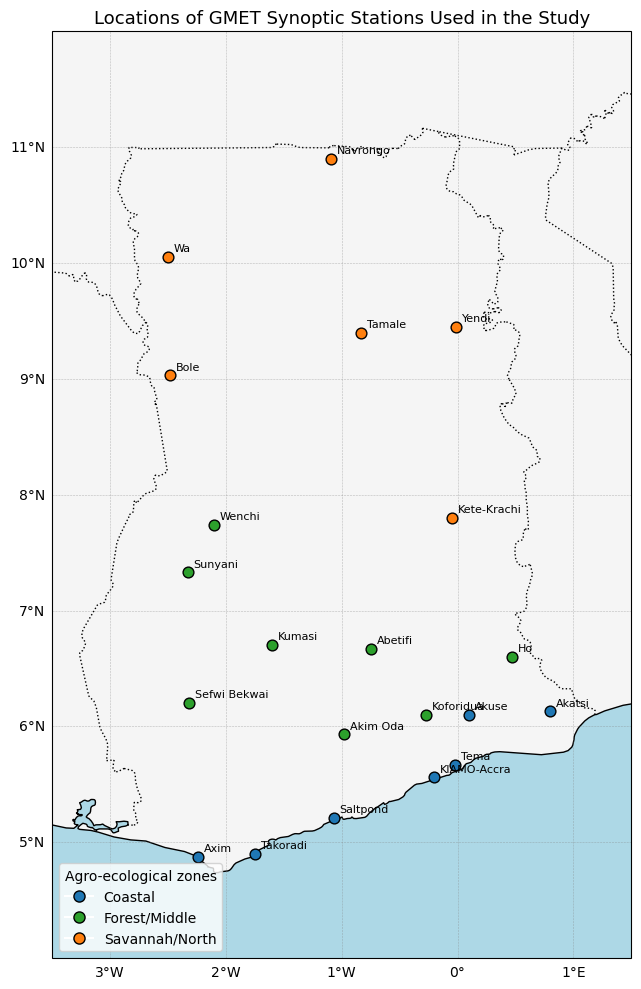

In [6]:
# Station coordinates (approx.). Update if you have official metadata.
station_coords = {
    "Abetifi": (6.67, -0.75),
    "Ada": (5.78, 0.62),
    "Akatsi": (6.13, 0.80),
    "Akim Oda": (5.93, -0.98),
    "Akuse": (6.10, 0.10),
    "Axim": (4.87, -2.24),
    "Bole": (9.03, -2.48),
    "Ho": (6.60, 0.47),
    "KIAMO-Accra": (5.56, -0.20),
    "Kete-Krachi": (7.80, -0.05),
    "Koforidua": (6.10, -0.27),
    "Kumasi": (6.70, -1.60),
    "Navrongo": (10.90, -1.09),
    "Saltpond": (5.21, -1.07),
    "Sefwi Bekwai": (6.20, -2.32),
    "Sunyani": (7.33, -2.33),
    "Takoradi": (4.90, -1.75),
    "Tamale": (9.40, -0.83),
    "Tema": (5.67, -0.02),
    "Wa": (10.05, -2.50),
    "Wenchi": (7.74, -2.10),
    "Yendi": (9.45, -0.01),
}

# Zones (feel free to tweak membership if you prefer)
ZONES = {
    "Coastal": [
        "KIAMO-Accra", "Tema", "Takoradi", "Axim", "Saltpond", "Akatsi", "Akuse"
    ],
    "Forest/Middle": [
        "Abetifi", "Akim Oda", "Koforidua", "Kumasi",
        "Sefwi Bekwai", "Sunyani", "Wenchi", "Ho"
    ],
    "Savannah/North": [
        "Bole", "Tamale", "Wa", "Yendi", "Navrongo", "Kete-Krachi"
    ],
}

zone_colors = {"Coastal":"tab:blue", "Forest/Middle":"tab:green", "Savannah/North":"tab:orange"}

plt.figure(figsize=(8.5,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-3.5, 1.5, 4, 12])
ax.add_feature(cfeature.OCEAN, facecolor="lightblue", zorder=0)
ax.add_feature(cfeature.LAND, facecolor="whitesmoke", zorder=0)
ax.add_feature(cfeature.COASTLINE, zorder=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=1)
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.right_labels = False
gl.top_labels = False

# plot each zone
for zone, stations in ZONES.items():
    for s in stations:
        if s not in station_coords: 
            continue
        lat, lon = station_coords[s]
        ax.scatter(lon, lat, s=60, color=zone_colors[zone], edgecolor="k", zorder=3)
        ax.text(lon+0.05, lat+0.05, s, fontsize=8, zorder=4)

# build legend
from matplotlib.lines import Line2D
handles = [Line2D([0],[0], marker='o', color='w', label=zn, markerfacecolor=col, markeredgecolor='k', markersize=8)
           for zn, col in zone_colors.items()]
ax.legend(handles=handles, title="Agro-ecological zones", loc="lower left")

plt.title("Locations of GMET Synoptic Stations Used in the Study", fontsize=13)
plt.tight_layout()
plt.savefig("map_gmet_stations.png", dpi=300)
plt.show()

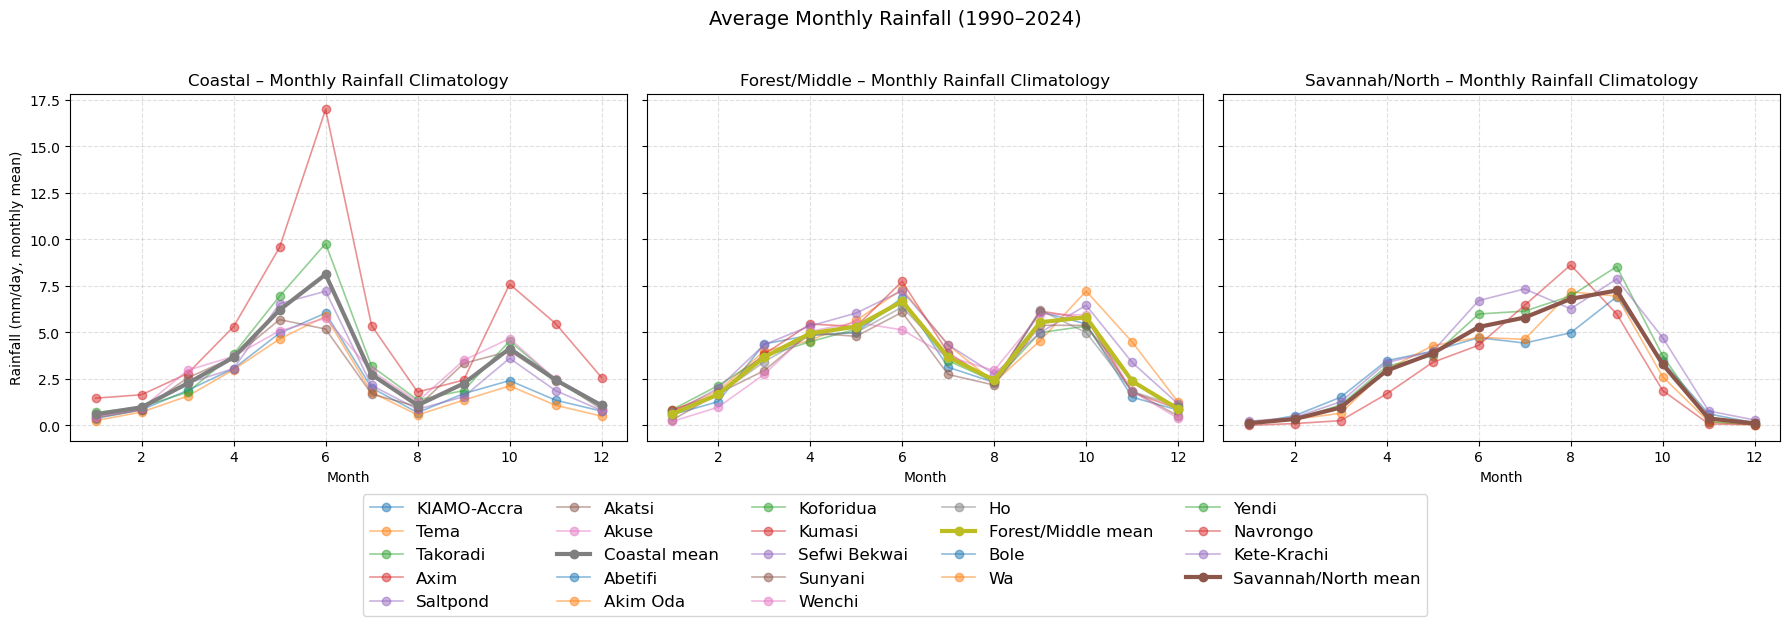

In [15]:
# ===== Monthly rainfall climatology by zone =====

RAIN_CSV = "rainfall_cleaned.csv"  # daily rainfall (mm), columns=stations, index=date

# Load and prep
rf = pd.read_csv(RAIN_CSV, parse_dates=["date"]).set_index("date").sort_index()
rf = rf.drop(columns=["Ada"], errors="ignore")  # if excluded earlier

# Monthly mean rainfall per station (climatology over all years)
monthly_rain = rf.groupby(rf.index.month).mean()   # 12 x stations
monthly_rain.index.name = "Month"

# Plot: one panel per zone, overlay all stations + zone mean
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
zone_order = ["Coastal", "Forest/Middle", "Savannah/North"]

for ax, zone in zip(axes, zone_order):
    stations = [s for s in ZONES[zone] if s in monthly_rain.columns]
    if not stations:
        ax.set_title(f"{zone} (no stations found)")
        continue
    zr = monthly_rain[stations]
    
    # plot each station
    for s in stations:
        ax.plot(zr.index, zr[s], alpha=0.5, marker='o', linewidth=1.2, label=s)
    # bold zone mean
    zmean = zr.mean(axis=1)
    ax.plot(zmean.index, zmean.values, marker='o', linewidth=3, label=f"{zone} mean")
    
    ax.set_title(f"{zone} – Monthly Rainfall Climatology")
    ax.set_xlabel("Month")
    ax.grid(True, linestyle="--", alpha=0.4)

axes[0].set_ylabel("Rainfall (mm/day, monthly mean)")
fig.suptitle("Average Monthly Rainfall (1990–2024)", fontsize=14)

# legend outside
handles, labels = axes[0].get_legend_handles_labels()
for ax in axes[1:]:
    h, l = ax.get_legend_handles_labels()
    for hi, li in zip(h, l):
        if li not in labels:
            handles.append(hi); labels.append(li)
fig.legend(handles, labels, loc="lower center", ncol=5, fontsize=12, bbox_to_anchor=(0.5, -0.25))  # centered under all plots
fig.tight_layout(rect=[0,0,1,0.95])  # leave room at bottom
# fig.tight_layout(rect=[0,0,0.95,0.95])
plt.savefig("climatology_monthly_rain_by_zone.png", dpi=300)
plt.show()


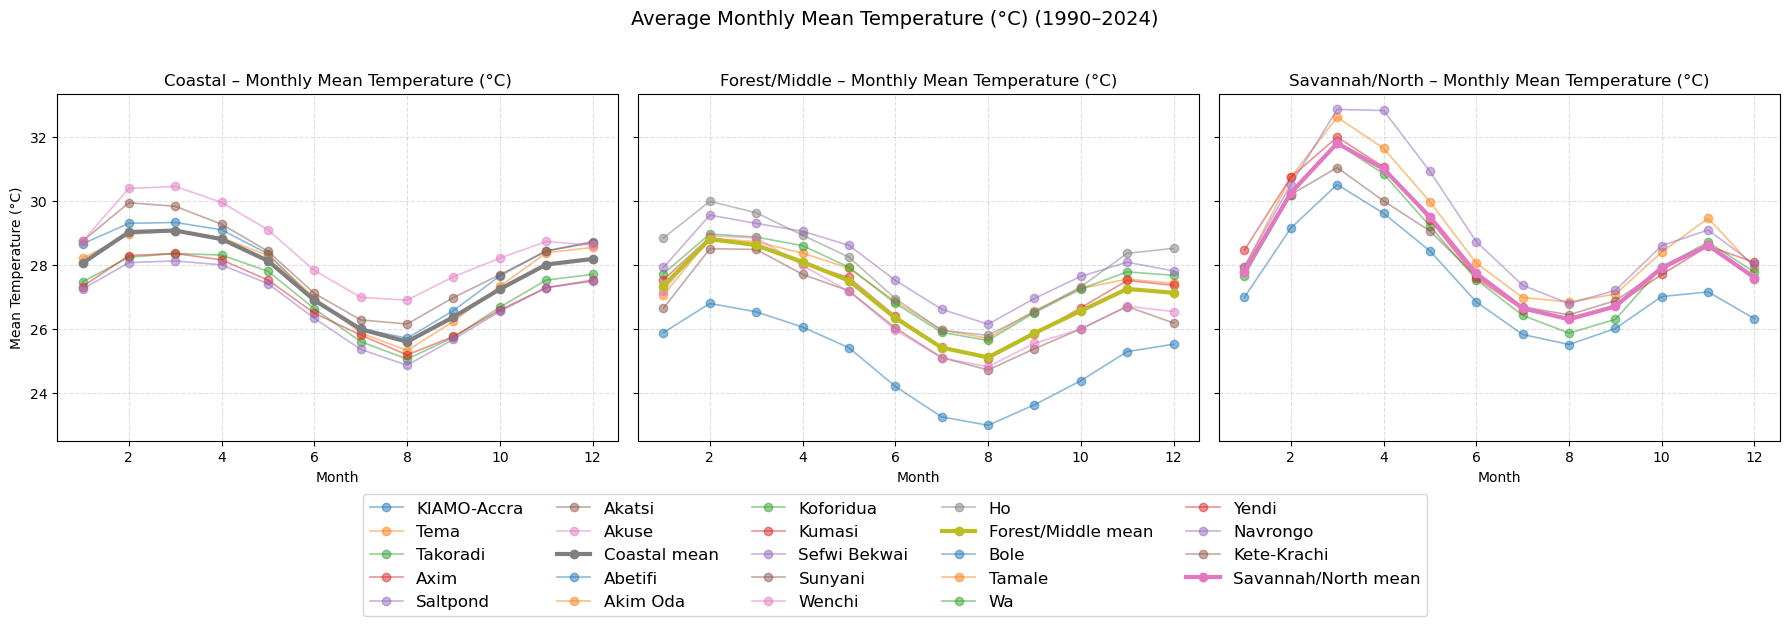

In [14]:
import os

TMIN_CSV = "cleaned_parameters_v2/minimum_temperatures.csv"
TMAX_CSV = "cleaned_parameters_v2/maximum_temperatures.csv"

tmin, tmax = None, None
if os.path.exists(TMIN_CSV):
    tmin = pd.read_csv(TMIN_CSV, parse_dates=["date"]).set_index("date").sort_index()
if os.path.exists(TMAX_CSV):
    tmax = pd.read_csv(TMAX_CSV, parse_dates=["date"]).set_index("date").sort_index()

if tmin is None and tmax is None:
    print("No temperature files found. Skipping temperature climatology.")
else:
    # align, drop Ada if needed
    if tmin is not None:
        tmin = tmin.drop(columns=["Ada"], errors="ignore")
    if tmax is not None:
        tmax = tmax.drop(columns=["Ada"], errors="ignore")

    # Build daily mean temperature if both available; else use whichever exists
    if (tmin is not None) and (tmax is not None):
        common_cols = [c for c in tmin.columns if c in tmax.columns]
        T = (tmin[common_cols] + tmax[common_cols]) / 2.0
        T_label = "Mean Temperature (°C)"
    elif tmin is not None:
        T = tmin.copy()
        T_label = "Minimum Temperature (°C)"
    else:
        T = tmax.copy()
        T_label = "Maximum Temperature (°C)"

    monthly_temp = T.groupby(T.index.month).mean()  # 12 x stations
    monthly_temp.index.name = "Month"

    fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
    zone_order = ["Coastal", "Forest/Middle", "Savannah/North"]

    for ax, zone in zip(axes, zone_order):
        stations = [s for s in ZONES[zone] if s in monthly_temp.columns]
        if not stations:
            ax.set_title(f"{zone} (no stations found)")
            continue
        zt = monthly_temp[stations]

        for s in stations:
            ax.plot(zt.index, zt[s], alpha=0.5, marker='o', linewidth=1.2, label=s)
        zmean = zt.mean(axis=1)
        ax.plot(zmean.index, zmean.values, marker='o', linewidth=3, label=f"{zone} mean")

        ax.set_title(f"{zone} – Monthly {T_label}")
        ax.set_xlabel("Month")
        ax.grid(True, linestyle="--", alpha=0.4)

    axes[0].set_ylabel(T_label)
    fig.suptitle(f"Average Monthly {T_label} (1990–2024)", fontsize=14)

    handles, labels = axes[0].get_legend_handles_labels()
    for ax in axes[1:]:
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li not in labels:
                handles.append(hi); labels.append(li)
    # fig.legend(handles, labels, loc="center right", bbox_to_anchor=(0.98, 0.5), fontsize=8)
    fig.legend(handles, labels,
           loc="lower center", ncol=5, fontsize=12,
           bbox_to_anchor=(0.5, -0.25))  # centered under all plots
    fig.tight_layout(rect=[0,0,1,0.95])  # leave room at bottom

    plt.savefig("climatology_monthly_temperature_by_zone.png", dpi=300)
    plt.show()